In [1]:
from __future__ import print_function
import os.path
import dalmatian as dm
import pandas as pd
import gzip
import sys
from src.CCLE_postp_function import *
sys.path.insert(0, '../JKBio/')
import Datanalytics as da 
import TerraFunction as terra
from Helper import * 
%load_ext autoreload
%autoreload 2
%load_ext rpy2.ipython
from IPython.display import Image,display
from taigapy import TaigaClient
tc = TaigaClient()
import numpy as np
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from bokeh.plotting import *
from bokeh.models import HoverTool
output_notebook()
from collections import OrderedDict
from gsheets import Sheets
sheets = Sheets.from_files('~/.client_secret.json', '~/.storage.json')
replace = {'T': 'Tumor', 'N': 'Normal', 'm': 'Unknown', 'L': 'Unknown'}

you need to have installed JKBio in the same folder as ccle_processing


Loading BokehJS ...

In [2]:
samplesetname="20Q1"
prevname="19Q4"
prevprevname = "19Q3"
prevprevversion='17'
virtual_public='public-20q1-c3b6'
virtual_dmc='dmc-20q1-c1d7'
virtual_internal='internal-20q1-f1a0'

workspace1="broad-genomics-delivery/Getz_IBM_CellLines_RNASeqData"
workspace2="broad-firecloud-ccle/CCLE_DepMap_RNAseq"
workspace3="broad-genomics-delivery/CCLE_DepMap_RNAseq"
workspace4="broad-genomics-delivery/Cancer_Cell_Line_Factory_CCLF_RNAseq"
workspace5="nci-mimoun-bi-org/CCLF_RNA_2_0"
refworkspace="broad-firecloud-ccle/DepMap_hg38_RNAseq"
source1="ibm"
source2="ccle"
source3="ccle"
source4="cclf"
source5="cclf"
release = samplesetname
sheeturl = "https://docs.google.com/spreadsheets/d/115TUgA1t_mD32SnWAGpW9OKmJ2W5WYAOs3SuSdedpX4"

In [3]:
%%R
genome_version <- 'hg38'
release <- '20Q1'
hg38_cyto_band_reference <- '../JKBio/data/hg38_cytoband.gz'

# Generate sample set from new samples

In [4]:
extract_to_change = {'ref_bams':'RNAseq_bam','ref_bais':"RNAseq_bai"}

In [5]:
wm1 = dm.WorkspaceManager(workspace1)
wm2 = dm.WorkspaceManager(workspace2)
wm3 = dm.WorkspaceManager(workspace3)
# wm4 = dm.WorkspaceManager(workspace4)
refwm = dm.WorkspaceManager(refworkspace)

In [34]:
sample_ids, refsamples, ccle_name = createDatasetWithNewCellLines(refworkspace, samplesetname, wmfroms = [workspace1, workspace2, workspace3], sources=[source1, source2, source3], gsfolderto='gs://ccle_bams/rna/', match='ACH', participantslicepos=10, accept_unknowntypes=True, extract=extract_to_change, dry_run = True)

you need to have installed JKBio in the same folder as ccle_processing
Getting sample infos...

The shape of the sample tsv from <dalmatian.wmanager.WorkspaceManager broad-genomics-delivery/Getz_IBM_CellLines_RNASeqData>: (119, 242)
Identifying any true duplicates by checking file sizes (this runs for each data source)...
This step can take a while as we need to use gsutil to check the size of each potential duplicate...
> /home/jeremie/ccle_processing/src/CCLE_postp_function.py(130)createDatasetWithNewCellLines()
-> tolookfor = [val[extract['bam']] for _, val in samples.iterrows() if val[extract['id']][0:participantslicepos] in set(refids)]
(Pdb) n
> /home/jeremie/ccle_processing/src/CCLE_postp_function.py(131)createDatasetWithNewCellLines()
-> sample_size = {gcp.extractSize(val): gcp.extractPath(val) for val in gcp.lsFiles(tolookfor, "-al")}
(Pdb) n
> /home/jeremie/ccle_processing/src/CCLE_postp_function.py(133)createDatasetWithNewCellLines()
-> dups_to_remove = [sample_size[a] for a

(Pdb) c
Len of samples before removal: 119
These bam file path do not exist: {'gs://fc-8a38e8a8-44ef-44c6-9bb8-4201797c5d7f/Getz_IBM_DMX_CellLines_10samples_Truseq_100M_12082018/RP-1420/RNA/SKGII/v1/SKGII.bam', 'gs://fc-8a38e8a8-44ef-44c6-9bb8-4201797c5d7f/Getz_IBM_DMX_CellLines_10samples_Truseq_100M_12082018/RP-1420/RNA/HT144SKINFV1/v1/HT144SKINFV1.bam', 'gs://fc-8a38e8a8-44ef-44c6-9bb8-4201797c5d7f/Getz_IBM_DMX_CellLines_10samples_Truseq_100M_12082018/RP-1420/RNA/HT144SKINFV2/v1/HT144SKINFV2.bam', 'gs://fc-8a38e8a8-44ef-44c6-9bb8-4201797c5d7f/Getz_IBM_DMX_CellLines_10samples_Truseq_100M_12082018/RP-1420/RNA/HT144SKINFV3/v1/HT144SKINFV3.bam', 'gs://fc-8a38e8a8-44ef-44c6-9bb8-4201797c5d7f/Getz_IBM_DMX_CellLines_10samples_Truseq_100M_12082018/RP-1420/RNA/RVH421SKINFV1/v1/RVH421SKINFV1.bam', 'gs://fc-8a38e8a8-44ef-44c6-9bb8-4201797c5d7f/Getz_IBM_DMX_CellLines_10samples_Truseq_100M_12082018/RP-1420/RNA/HCSC1/v1/HCSC1.bam', 'gs://fc-8a38e8a8-44ef-44c6-9bb8-4201797c5d7f/Getz_IBM_DMX_CellLin


The shape of the sample tsv from <dalmatian.wmanager.WorkspaceManager broad-firecloud-ccle/CCLE_DepMap_RNAseq>: (13, 225)
Identifying any true duplicates by checking file sizes (this runs for each data source)...
This step can take a while as we need to use gsutil to check the size of each potential duplicate...
> /home/jeremie/ccle_processing/src/CCLE_postp_function.py(129)createDatasetWithNewCellLines()
-> pdb.set_trace()
(Pdb) c
Len of samples before removal: 13
These bam file path do not exist: set()
Dups from <dalmatian.wmanager.WorkspaceManager broad-firecloud-ccle/CCLE_DepMap_RNAseq> has len 13:
 ['gs://fc-7dc66c19-16af-4fe8-ba2b-7e560be72052/DepMap_CellLine_April2019/RP-1561/RNA/OCILY7/v1/OCILY7.bam', 'gs://fc-7dc66c19-16af-4fe8-ba2b-7e560be72052/DepMap_CellLine_April2019/RP-1561/RNA/OMM25/v1/OMM25.bam', 'gs://fc-7dc66c19-16af-4fe8-ba2b-7e560be72052/DepMap_CellLine_RNAseq_Feb2019/RP-1561/RNA/VAESBJ/v2/VAESBJ.bam', 'gs://fc-7dc66c19-16af-4fe8-ba2b-7e560be72052/DepMap_CellLine_R

/home/jeremie/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/jeremie/ccle_processing/src/CCLE_postp_function.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tolookfor = [val[extract['bam']] for _, val in samples.iterrows() if val[extract['id']][0:participantslicepos] in set(refids)]
/home/jeremie/ccle_processing/src/CCLE_postp_function.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the ca

In [46]:
sample_ids,ccle_name

(['ACH-001847_1',
  'ACH-001533_1',
  'ACH-002014_1',
  'ACH-001574_1',
  'ACH-001625_1'],
 ['ICC7', 'KARPAS1718', 'MEL270', 'MOLM14', 'OSC19'])

In [44]:
sample_ids, refsamples, ccle_name = createDatasetWithNewCellLines(refworkspace, samplesetname, wmfroms = [workspace1, workspace2, workspace3], sources=[source1, source2, source3], gsfolderto='gs://ccle_bams/rna/', match='ACH', participantslicepos=10, accept_unknowntypes=True, extract=extract_to_change, dry_run = False)

you need to have installed JKBio in the same folder as ccle_processing
Getting sample infos...

The shape of the sample tsv from <dalmatian.wmanager.WorkspaceManager broad-genomics-delivery/Getz_IBM_CellLines_RNASeqData>: (119, 242)
Identifying any true duplicates by checking file sizes (this runs for each data source)...
This step can take a while as we need to use gsutil to check the size of each potential duplicate...
Len of samples before removal: 119
These bam file path do not exist: {'gs://fc-8a38e8a8-44ef-44c6-9bb8-4201797c5d7f/Getz_IBM_DMX_CellLines_10samples_Truseq_100M_12082018/RP-1420/RNA/SKGII/v1/SKGII.bam', 'gs://fc-8a38e8a8-44ef-44c6-9bb8-4201797c5d7f/Getz_IBM_DMX_CellLines_10samples_Truseq_100M_12082018/RP-1420/RNA/HT144SKINFV1/v1/HT144SKINFV1.bam', 'gs://fc-8a38e8a8-44ef-44c6-9bb8-4201797c5d7f/Getz_IBM_DMX_CellLines_10samples_Truseq_100M_12082018/RP-1420/RNA/HT144SKINFV2/v1/HT144SKINFV2.bam', 'gs://fc-8a38e8a8-44ef-44c6-9bb8-4201797c5d7f/Getz_IBM_DMX_CellLines_10samples


The shape of the sample tsv from <dalmatian.wmanager.WorkspaceManager broad-firecloud-ccle/CCLE_DepMap_RNAseq>: (13, 225)
Identifying any true duplicates by checking file sizes (this runs for each data source)...
This step can take a while as we need to use gsutil to check the size of each potential duplicate...
Len of samples before removal: 13
These bam file path do not exist: set()
Dups from <dalmatian.wmanager.WorkspaceManager broad-firecloud-ccle/CCLE_DepMap_RNAseq> has len 13:
 ['gs://fc-7dc66c19-16af-4fe8-ba2b-7e560be72052/DepMap_CellLine_April2019/RP-1561/RNA/OCILY7/v1/OCILY7.bam', 'gs://fc-7dc66c19-16af-4fe8-ba2b-7e560be72052/DepMap_CellLine_April2019/RP-1561/RNA/OMM25/v1/OMM25.bam', 'gs://fc-7dc66c19-16af-4fe8-ba2b-7e560be72052/DepMap_CellLine_RNAseq_Feb2019/RP-1561/RNA/VAESBJ/v2/VAESBJ.bam', 'gs://fc-7dc66c19-16af-4fe8-ba2b-7e560be72052/DepMap_CellLine_RNAseq_Feb2019/RP-1561/RNA/LPS141/v2/LPS141.bam', 'gs://fc-7dc66c19-16af-4fe8-ba2b-7e560be72052/DepMap_CellLine_RNAseq_Feb2

/home/jeremie/ccle_processing/src/CCLE_postp_function.py:151: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samples[extract['id']][i] = val + '_' + str(num_in_workspace + 1)


Len of samples before removal: 68
These bam file path do not exist: set()
Dups from <dalmatian.wmanager.WorkspaceManager broad-genomics-delivery/CCLE_DepMap_RNAseq> has len 63:
 ['gs://fc-d04af879-9884-42a5-a40a-964d7ab6954d/CCLE_DepMap_RNAseq_July_Dec_2018/RP-1561/RNA/OCUG1/v2/OCUG1.bam', 'gs://fc-d04af879-9884-42a5-a40a-964d7ab6954d/DepMap_CellLine_RNAseq_Sept2019/RP-1561/RNA/FARAGE/v1/FARAGE.bam', 'gs://fc-d04af879-9884-42a5-a40a-964d7ab6954d/CCLE_DepMap_RNAseq_July_Dec_2018/RP-1561/RNA/ICC108/v1/ICC108.bam', 'gs://fc-d04af879-9884-42a5-a40a-964d7ab6954d/CCLE_DepMap_RNAseq_July_Dec_2018/RP-1561/RNA/TKKK/v3/TKKK.bam', 'gs://fc-d04af879-9884-42a5-a40a-964d7ab6954d/CCLE_DepMap_RNAseq_July_Dec_2018/RP-1561/RNA/YSCCC/v2/YSCCC.bam', 'gs://fc-d04af879-9884-42a5-a40a-964d7ab6954d/CCLE_DepMap_RNAseq_July_Dec_2018/RP-1561/RNA/SNU638/v1/SNU638.bam', 'gs://fc-d04af879-9884-42a5-a40a-964d7ab6954d/DepMap_CellLine_RNAseq_June2019/RP-1561/RNA/RPE1SS77/v2/RPE1SS77.bam', 'gs://fc-d04af879-9884-42a5-a

(Pdb) 
> /home/jeremie/ccle_processing/src/CCLE_postp_function.py(178)createDatasetWithNewCellLines()
-> if res != 0:
(Pdb) 
> /home/jeremie/ccle_processing/src/CCLE_postp_function.py(174)createDatasetWithNewCellLines()
-> for i, val in sampless.iterrows():
(Pdb) 
> /home/jeremie/ccle_processing/src/CCLE_postp_function.py(175)createDatasetWithNewCellLines()
-> if not gcp.exists(gsfolderto + 'v' + str(val["version"]) + '/' + val[extract['bam']].split('/')[-1]):
(Pdb) 
> /home/jeremie/ccle_processing/src/CCLE_postp_function.py(176)createDatasetWithNewCellLines()
-> cmd = 'gsutil cp ' + val[extract['bam']] + ' ' + val[extract['bai']] + ' ' + gsfolderto + 'v' + str(val["version"]) + '/'
(Pdb) 
> /home/jeremie/ccle_processing/src/CCLE_postp_function.py(177)createDatasetWithNewCellLines()
-> res = os.system(cmd)
(Pdb) 
> /home/jeremie/ccle_processing/src/CCLE_postp_function.py(178)createDatasetWithNewCellLines()
-> if res != 0:
(Pdb) unt
> /home/jeremie/ccle_processing/src/CCLE_postp_functio

BdbQuit: 

## Check that we have all the cell lines we expect for this release
This involves comparing to the list in the Google sheet "Cell Line Profiling Status."

In [ ]:
# this function may not work - it hasn't been tested
url = 'https://docs.google.com/spreadsheets/d/1qus-9TKzqzwUMNWp8S1QP4s4-3SsMo2vuQRZrNXf7ag/edit?ts=5db85e27#gid=0&fvid=1627883727'

compareToCuratedGS(url, sample = newsample[0], samplesetname = samplesetname, colname = 'RNA New to internal')

# run Terra pipeline

We are using Dalmatian to send request to Terra, we are running a set of 6 functions To generate the expression/fusion dataset:

We use the GTEx pipeline ([https://github.com/broadinstitute/gtex-pipeline/blob/v9/TOPMed_RNAseq_pipeline.md](https://github.com/broadinstitute/gtex-pipeline/blob/v9/TOPMed_RNAseq_pipeline.md)).

To generate the expression dataset, run the following tasks on all samples that you need, in this order:



*   samtofastq_v1-0_BETA_cfg 

    (broadinstitute_gtex/samtofastq_v1-0_BETA Snapshot ID: 5)

*   star_v1-0_BETA_cfg

(broadinstitute_gtex/star_v1-0_BETA Snapshot ID: 7)



*   rsem_v1-0_BETA_cfg 

    (broadinstitute_gtex/rsem_v1-0_BETA Snapshot ID: 4)

*   rsem_aggregate_results_v1-0_BETA_cfg (broadinstitute_gtex/rsem_aggregate_results_v1-0_BETA Snapshot ID: 3)

The outputs to be downloaded will be saved under the sample set that you ran. The outputs we use for the release are:



*   rsem_genes_expected_count
*   rsem_genes_tpm
*   rsem_transcripts_tpm

****Make sure that you delete the intermediate files. These files are quite large so cost a lot to store. To delete, you can either write a task that deletes them or use gsutil rm*****


##### Fusions {#fusions}

We use STAR-Fusion [https://github.com/STAR-Fusion/STAR-Fusion/wiki](https://github.com/STAR-Fusion/STAR-Fusion/wiki). The fusions are generated by running the following tasks



*   hg38_STAR_fusion (gkugener/STAR_fusion Snapshot ID: 14)
*   Aggregate_Fusion_Calls (gkugener/Aggregate_files_set Snapshot ID: 2)

The outputs to be downloaded will be saved under the sample set you ran. The outputs we use for the release are: 



*   fusions_star

This task uses the same samtofastq_v1-0_BETA_cfg task as in the expression pipeline, although in the current implementation, this task will be run twice. It might be worth combing the expression/fusion calling into a single workflow. This task also contains a flag that lets you specify if you want to delete the intermediates (fastqs). 

There are several other tasks in this workspace. In brief:



*   Tasks prefixed with **EXPENSIVE** or **CHEAP** are identical to their non-prefixed version, except that they specify different memory, disk space, etc. parameters. These versions can be used when samples fail the normal version of the task due to memory errors.
*   The following tasks are part of the GTEx pipeline but we do not use them (we use RSEM exclusively): markduplicates_v1-0_BETA_cfg (broadinstitute_gtex/markduplicates_v1-0_BETA Snapshot ID: 2), rnaseqc2_v1-0_BETA_cfg (broadinstitute_gtex/rnaseqc2_v1-0_BETA Snapshot ID: 2)
*   **ExonUsage_hg38_fixed** (gkugener/ExonUsage_fixed Snapshot ID: 1): this task calculates exon usage ratios. The non-fixed version contains a bug in the script that is not able to handle chromosome values prefixed with ‘chr’. The ‘fixed’ version resolves this issue.
*   **AggregateExonUsageRObj_hg38** (ccle_mg/AggregateExonUsageRObj Snapshot ID: 2): combines the exon usage ratios into a matrices that are saved in an R object.

## On Terra

In [5]:
submission_id = refwm.create_submission("samtofastq_v1-0_BETA_cfg", samplesetname,'sample_set',expression='this.samples')
terra.waitForSubmission(refworkspace, submission_id)

1.0 of jobs Succeeded in submission 0.sion 0. 46 mn elapsed.


[]

In [6]:
submission_id = refwm.create_submission("star_v1-0_BETA_cfg", samplesetname,'sample_set',expression='this.samples')
terra.waitForSubmission(refworkspace, submission_id)

Successfully created submission d20a2c65-fbf2-4fe7-91f7-3be69b76de0a.
1.0 of jobs Succeeded in submission 0.sion 0. 148 mn elapsed.


[]

In [7]:
submission_id1 = refwm.create_submission("rsem_v1-0_BETA_cfg", samplesetname,'sample_set',expression='this.samples')
terra.waitForSubmission(refworkspace, submission_id1)

Successfully created submission e18e5d64-5375-4885-825e-6ea9537dc9d8.
1.0 of jobs Succeeded in submission 0.sion 0. 494 mn elapsed.


[]

In [8]:
submission_id2 = refwm.create_submission("hg38_STAR_fusion", samplesetname,'sample_set',expression='this.samples')

Successfully created submission ef80a3fd-13f6-4140-9475-c4222d02763e.


In [9]:
submission_id_snp = refwm.create_submission("rnaseq-germline-snps-indels", samplesetname,'sample_set',expression='this.samples')

ConfigNotFound: 'No configurations with name rnaseq-germline-snps-indels in workspace broad-firecloud-ccle/DepMap_hg38_RNAseq'

In [14]:
# update a samples set with another sampleset
terra.updateAllSampleSet(refworkspace, samplesetname)

Sample set "All_samples" (1388 samples) successfully updated.


In [15]:
submission_id1 = refwm.create_submission("rsem_aggregate_results", 'All_samples')

Successfully created submission dfc55606-acf5-477d-93c0-53d0acb491c5.


In [17]:
terra.waitForSubmission(refworkspace, [submission_id1])#submission_id_snp])

1.0 of jobs Succeeded in submission 0.sion 0. 150 mn elapsed.


[]

## On Local

### Save the workflow configurations used

In [20]:
terra.saveConfigs(refworkspace,'data/'+samplesetname+'/RNAconfig')

### Expression post processing

Here we get all data and remove the duplicates directly with the function `removeDuplicates`

we then run:

- readTranscripts
- readCounts
- readTPM
- renameFunction

- Allie's gene renaming / filtering and log transform

In [100]:
res = refwm.get_sample_sets().loc['All_samples']
rsem_genes_expected_count = res['rsem_genes_expected_count']
rsem_genes_tpm = res['rsem_genes_tpm']
rsem_transcripts_tpm = res['rsem_transcripts_tpm']
! gsutil cp $rsem_genes_expected_count "temp/expression.expectedcount" & gsutil cp $rsem_genes_tpm "temp/expression.genes.tpm" & gsutil cp $rsem_transcripts_tpm "temp/expression.transcript.tpm"

Copying gs://fc-secure-639c94ba-2b0d-4960-92fc-9cd50046a968/dfc55606-acf5-477d-93c0-53d0acb491c5/rsem_aggregate_results_workflow/a7231096-176b-462f-9464-6e7a9966ef2b/call-rsem_aggregate_results/All_samples.rsem_transcripts_tpm.txt.gz...
Copying gs://fc-secure-639c94ba-2b0d-4960-92fc-9cd50046a968/dfc55606-acf5-477d-93c0-53d0acb491c5/rsem_aggregate_results_workflow/a7231096-176b-462f-9464-6e7a9966ef2b/call-rsem_aggregate_results/All_samples.rsem_genes_tpm.txt.gz...
Copying gs://fc-secure-639c94ba-2b0d-4960-92fc-9cd50046a968/dfc55606-acf5-477d-93c0-53d0acb491c5/rsem_aggregate_results_workflow/a7231096-176b-462f-9464-6e7a9966ef2b/call-rsem_aggregate_results/All_samples.rsem_genes_expected_count.txt.gz...
- [1 files][ 69.9 MiB/ 69.9 MiB]                                                
Operation completed over 1 objects/69.9 MiB.                                     
\ [1 files][ 72.9 MiB/ 72.9 MiB]                                                
Operation completed over 1 objects/72.9 MiB.  

In [142]:
[file.columns[i] for i in range(len(file.columns)-1) if file.columns[i] == file.columns[i+1]]

[]

In [138]:
len(file.columns) - len((set(file.columns)))

0

In [139]:
for val in ["temp/expression.expectedcount","temp/expression.transcript.tpm","temp/expression.genes.tpm"]:
    file = pd.read_csv(val, compression='gzip', header=0, sep='\t', quotechar='"', error_bad_lines=False)
    file = removeColDuplicates(file)
    file.columns = [i.split('_')[0] if i not in ['gene_id', "transcript_id" "transcript_id(s)"] else i for i in file.columns]
    file.set_index('gene_id').to_csv(val,sep='\t',)

OSError: Not a gzipped file (b'ge')

In [113]:
%%R
library('taigr')
source('../gkugener/RScripts/load_libraries_and_annotations.R')
source('src/CCLE_postp_function.R')
library('cdsomics')

you need to have installed JKBio in the same folder as ccle_processing


In [114]:
%%R
# These files are downloaded from FireCloud/Terra
download_paths <- list(
  tpm_genes='temp/expression.genes.tpm',
  tpm_transcripts='temp/expression.transcript.tpm',
  counts_genes='temp/expression.expectedcount')

In [115]:
%%R
tpm_transcripts = readTranscripts(download_paths$tpm_transcripts)
counts_genes = readCounts(download_paths$counts_genes)
tpm_genes = readTPM(download_paths$tpm_genes)

R[write to console]: Parsed with column specification:
cols(
  .default = col_double(),
  gene_id = col_character(),
  transcript = col_character()
)

R[write to console]: See spec(...) for full column specifications.

R[write to console]: Parsed with column specification:
cols(
  .default = col_double(),
  gene_id = col_character(),
  transcript = col_character()
)

R[write to console]: See spec(...) for full column specifications.

R[write to console]: Parsed with column specification:
cols(
  .default = col_double(),
  gene_id = col_character(),
  transcript = col_character()
)

R[write to console]: See spec(...) for full column specifications.



In [116]:
%%R
head(tpm_transcripts)

# A tibble: 6 x 1,383
  gene_id `ACH-000001` `ACH-000002` `ACH-000003` `ACH-000004` `ACH-000005`
  <chr>          <dbl>        <dbl>        <dbl>        <dbl>        <dbl>
1 ENSG00…        52.2          0.05        61.7          4.3          6.72
2 ENSG00…         0            0            0            0            0   
3 ENSG00…         2.48         0            1.79         0.47         0.44
4 ENSG00…         1            0.01         0.63         0.07         0.1 
5 ENSG00…         0            0.08         0.5          0.23         0.02
6 ENSG00…         0            0            0            0            0   
# … with 1,377 more variables: `ACH-000006` <dbl>, `ACH-000007` <dbl>,
#   `ACH-000008` <dbl>, `ACH-000009` <dbl>, `ACH-000010` <dbl>,
#   `ACH-000011` <dbl>, `ACH-000012` <dbl>, `ACH-000013` <dbl>,
#   `ACH-000014` <dbl>, `ACH-000015` <dbl>, `ACH-000016` <dbl>,
#   `ACH-000017` <dbl>, `ACH-000018` <dbl>, `ACH-000019` <dbl>,
#   `ACH-000020` <dbl>, `ACH-000021` <dbl>, `ACH-00

In [117]:
%%R
# Fix the colnames (for cases where there are mixed values (CCLE_name and DepMap_IDs))
colnames(counts_genes) %<>% renameFunction(.)
colnames(tpm_genes) %<>% renameFunction(.)
colnames(tpm_transcripts) %<>% renameFunction(.)

### data exploration and QC

- we QC on the amount of genes with 0 counts for each samples

In [118]:
%%R 
# Quick QC
# We are looking for samples with a worrying amount of zeros
zero_threshold <- 39000
number_zeros <- apply(tpm_genes[,2:ncol(tpm_genes)-1] ==0, 2, FUN = sum)
nzdf <- data.frame(CL=names(number_zeros), nz=number_zeros, stringsAsFactors = F)

In [119]:
%%R
number_zeros <- number_zeros[order(-number_zeros)]
number_zeros <- number_zeros[number_zeros < zero_threshold]
pass <- number_zeros %>% names()

In [120]:
%%R
counts_genes

# A tibble: 58,813 x 1,383
   gene_id `ACH-000001` `ACH-000002` `ACH-000003` `ACH-000004` `ACH-000005`
   <chr>          <dbl>        <dbl>        <dbl>        <dbl>        <dbl>
 1 ENSG00…        4251           14         7568          485          710 
 2 ENSG00…           0            0            1            0            0 
 3 ENSG00…        5339         2843        10643         1743         2198 
 4 ENSG00…         574.         496.         643.         967.        1373.
 5 ENSG00…        1398         1273.        1367.        1495         3866.
 6 ENSG00…           1         2444            0           83           19 
 7 ENSG00…          72           29            8         5046.        8770.
 8 ENSG00…        4020.        2442.       11743         1474.        1736.
 9 ENSG00…        2365.        3667         3833         3633         5956 
10 ENSG00…        1920         1493         2939         4634         6465 
# … with 58,803 more rows, and 1,377 more variables: `ACH-000

In [125]:
%%R
colnames(tpm_transcripts)[which(colnames(tpm_transcripts)=='transcript')] <- 'transcript_id(s)'
colnames(tpm_genes)[which(colnames(tpm_genes)=='transcript')] <- 'transcript_id(s)'
colnames(counts_genes)[which(colnames(counts_genes)=='transcript')] <- 'transcript_id(s)'

In [127]:
%%R
# These samples failed
failed <- setdiff(colnames(tpm_genes), pass) %>% .[!(. %in% c('gene_id', 'transcript_id(s)'))]

In [128]:
%%R
counts_genes

# A tibble: 58,813 x 1,383
   gene_id `ACH-000001` `ACH-000002` `ACH-000003` `ACH-000004` `ACH-000005`
   <chr>          <dbl>        <dbl>        <dbl>        <dbl>        <dbl>
 1 ENSG00…        4251           14         7568          485          710 
 2 ENSG00…           0            0            1            0            0 
 3 ENSG00…        5339         2843        10643         1743         2198 
 4 ENSG00…         574.         496.         643.         967.        1373.
 5 ENSG00…        1398         1273.        1367.        1495         3866.
 6 ENSG00…           1         2444            0           83           19 
 7 ENSG00…          72           29            8         5046.        8770.
 8 ENSG00…        4020.        2442.       11743         1474.        1736.
 9 ENSG00…        2365.        3667         3833         3633         5956 
10 ENSG00…        1920         1493         2939         4634         6465 
# … with 58,803 more rows, and 1,377 more variables: `ACH-000

In [129]:
%%R
counts_genes %<>% dplyr::select(c("gene_id","transcript_id(s)", pass))

In [130]:
%%R
failed

[1] "ACH-001388" "ACH-001577" "ACH-001767" "ACH-002463"


In [131]:
%%R
tpm_genes %<>% dplyr::select(c("gene_id","transcript_id(s)", pass))
tpm_transcripts %<>% dplyr::select(c("transcript_id(s)", "gene_id", pass))

In [132]:
%%R
# Plot of the samples that fail
plot <- ggplot(nzdf, aes(nz)) +
  geom_histogram(bins = 100, color='black', fill='white') +
  geom_vline(xintercept = zero_threshold, linetype=2) +
  geom_label_repel(data = nzdf %>% filter(nz > zero_threshold), aes(x=nz, y=0, label=CL), size=5, fill=rgb(1,1,1,0.5))

ggsave(plot, filename ='temp/ggplot.png', width=20, height = 20)

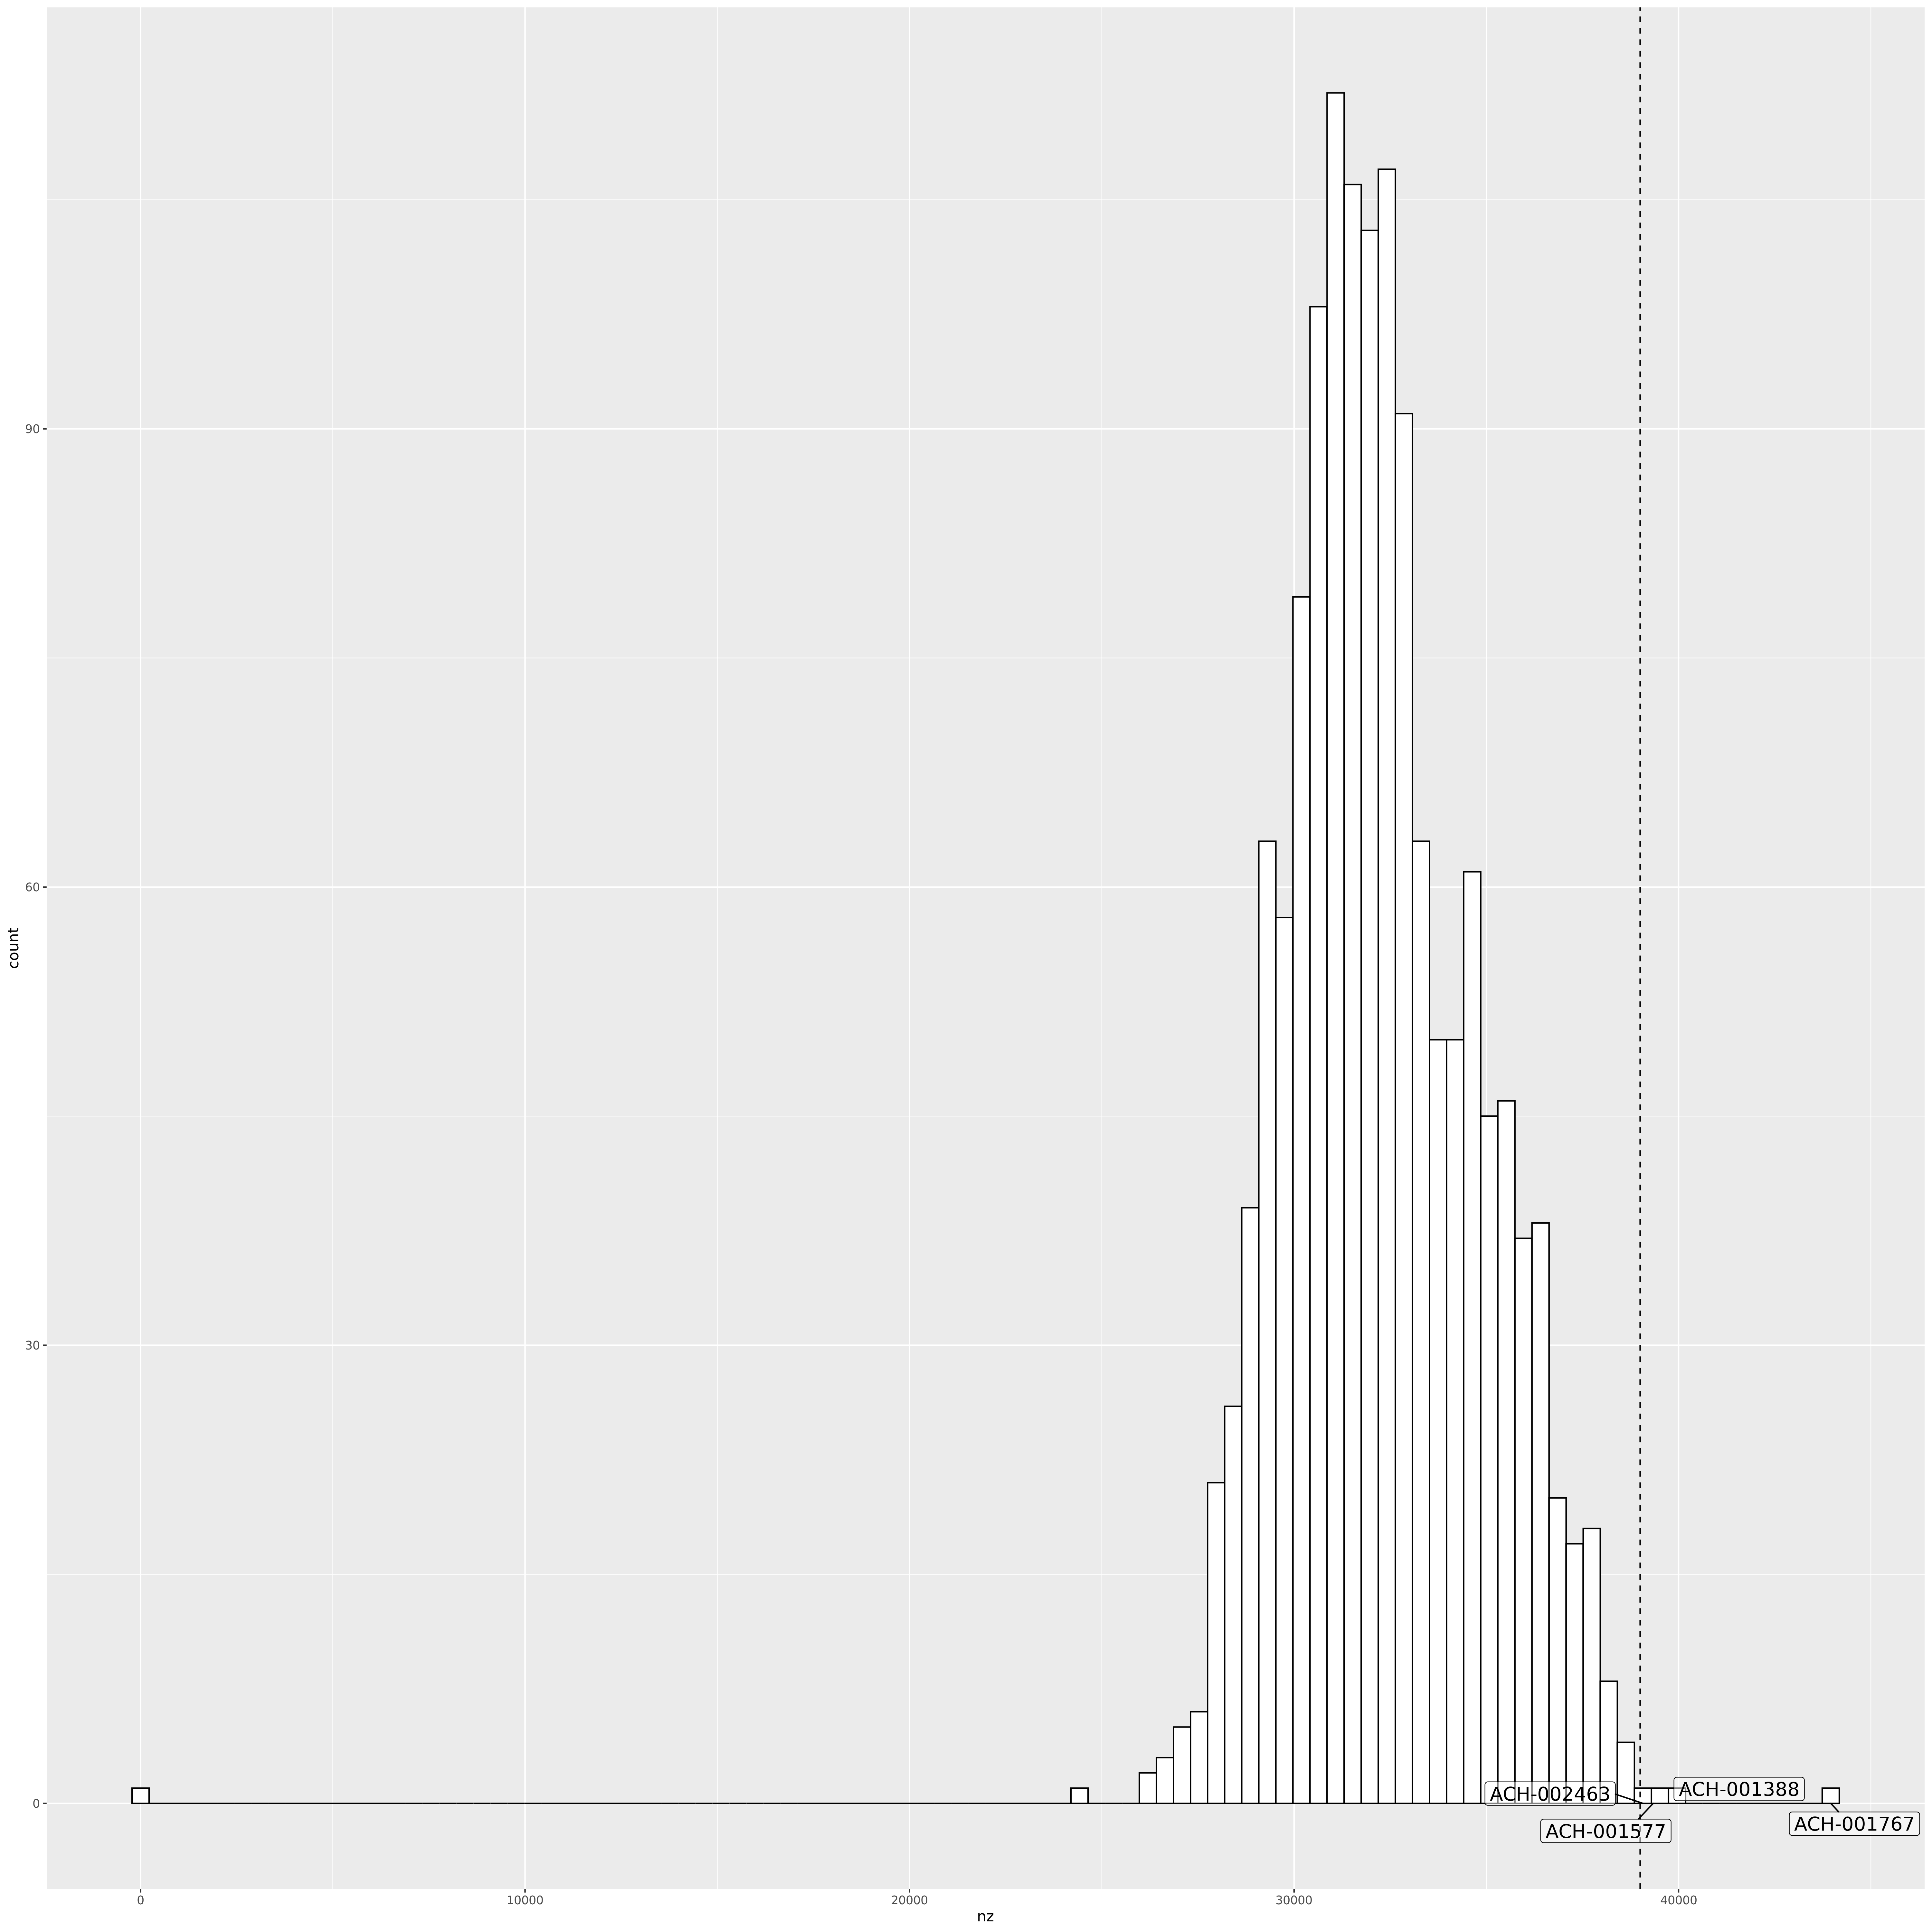

In [133]:
display(Image(filename='temp/ggplot.png'))

### Allie post processing 

In [125]:
%%R
colnames(tpm_transcripts)[which(colnames(tpm_transcripts)=='transcript')] <- 'transcript_id(s)'
colnames(tpm_genes)[which(colnames(tpm_genes)=='transcript')] <- 'transcript_id(s)'
colnames(counts_genes)[which(colnames(counts_genes)=='transcript')] <- 'transcript_id(s)'

In [134]:
%%R
print(colnames(tpm_genes)[1:10])
tpm_gene_ids <- gsub("\\..*", "", tpm_genes$gene_id)
if(nrow(tpm_genes) != length(unique(tpm_gene_ids))){
  print("Duplicated ensembl ids")
  print(nrow(tpm_genes) - length(unique(tpm_gene_ids)))
  tpm_genes <- tpm_genes[-which(duplicated(tpm_gene_ids)==T),]
}

 [1] "gene_id"          "transcript_id(s)" "ACH-001097"       "ACH-002466"      
 [5] "ACH-002467"       "ACH-001636"       "ACH-001698"       "ACH-002022"      
 [9] "ACH-001804"       "ACH-000534"      
[1] "Duplicated ensembl ids"
[1] 45


In [145]:
%%R
annotations<-download.raw.from.taiga(data.name='gene-annotations-e737', data.version=1, data.file='gencode.v29.annotation')
tpm_protein_coding <- prepare_depmap_TPM_for_taiga(tpm_genes, log_transform=T, just_protein_coding=T, gencode_annotations=annotations)
tpm_genes <- prepare_depmap_TPM_for_taiga(tpm_genes, log_transform=T, just_protein_coding=F, gencode_annotations=annotations)

Fetching https://cds.team/taiga/api/dataset/gene-annotations-e737/1 
Status 200 


R[write to console]: No encoding supplied: defaulting to UTF-8.



loading cached data version from  ~/.taiga/gene-annotations-e737_1.toc 
Checking for cached file ~/.taiga/ed503071a3944c3f8ad7c1a4e1680240_gencode-v29-annotation.raw 
Fetching https://cds.team/taiga/api/dataset/hgnc-87ab/3 
Status 200 


R[write to console]: No encoding supplied: defaulting to UTF-8.



loading cached data version from  /home/jeremie/.taiga/hgnc-87ab_3.toc 


R[write to console]: Loading from cached file /home/jeremie/.taiga/25d996d77e114d9c8c142ee48a90589f_hgnc-complete-set-2018q3.rds



[1] "1 duplicated ensembl ID(s)!"
Fetching https://cds.team/taiga/api/dataset/hgnc-87ab/3 
Status 200 


R[write to console]: No encoding supplied: defaulting to UTF-8.



loading cached data version from  /home/jeremie/.taiga/hgnc-87ab_3.toc 


R[write to console]: Loading from cached file /home/jeremie/.taiga/25d996d77e114d9c8c142ee48a90589f_hgnc-complete-set-2018q3.rds



[1] "using 19144 protein coding genes"
Fetching https://cds.team/taiga/api/dataset/hgnc-87ab/3 
Status 200 


R[write to console]: No encoding supplied: defaulting to UTF-8.



loading cached data version from  /home/jeremie/.taiga/hgnc-87ab_3.toc 


R[write to console]: Loading from cached file /home/jeremie/.taiga/25d996d77e114d9c8c142ee48a90589f_hgnc-complete-set-2018q3.rds



[1] "1 duplicated ensembl ID(s)!"


In [146]:
%%R
### transcripts
print(colnames(tpm_transcripts)[1:10])
tpm_transcript_id <- gsub("\\..*", "", tpm_transcripts$`transcript_id(s)`)
if(nrow(tpm_transcripts) != length(unique(tpm_transcript_id))) {
  print("Duplicated transcript ids")
  print(nrow(tpm_transcripts) - length(unique(tpm_transcript_id)))
  tpm_transcript <- tpm_transcripts[-which(duplicated(tpm_transcript_id)==T),]
}
tpm_transcripts <- prepare_depmap_transcripts_for_taiga(tpm_transcript, gencode_annotations = annotations) 

 [1] "transcript_id(s)" "gene_id"          "ACH-001097"       "ACH-002466"      
 [5] "ACH-002467"       "ACH-001636"       "ACH-001698"       "ACH-002022"      
 [9] "ACH-001804"       "ACH-000534"      
[1] "Duplicated transcript ids"
[1] 160


In [147]:
%%R
### counts
print(colnames(counts_genes)[1:10])
counts_gene_ids <- gsub("\\..*", "", counts_genes$gene_id)
if(nrow(counts_genes) != length(unique(counts_gene_ids))) {
  print("Duplicate ensembl ids")
  print(length(which(duplicated(counts_gene_ids)==T)))
  counts_genes <- counts_genes[-which(duplicated(counts_gene_ids)==T),]
}
counts_genes <- prepare_depmap_TPM_for_taiga(counts_genes, gencode_annotations =annotations) 

 [1] "gene_id"          "transcript_id(s)" "ACH-001097"       "ACH-002466"      
 [5] "ACH-002467"       "ACH-001636"       "ACH-001698"       "ACH-002022"      
 [9] "ACH-001804"       "ACH-000534"      
[1] "Duplicate ensembl ids"
[1] 45
Fetching https://cds.team/taiga/api/dataset/hgnc-87ab/3 
Status 200 


R[write to console]: No encoding supplied: defaulting to UTF-8.



loading cached data version from  /home/jeremie/.taiga/hgnc-87ab_3.toc 


R[write to console]: Loading from cached file /home/jeremie/.taiga/25d996d77e114d9c8c142ee48a90589f_hgnc-complete-set-2018q3.rds



[1] "1 duplicated ensembl ID(s)!"


In [151]:
%%R
write.table(
  counts_genes, 
  file = paste0('temp/expression.', release,'.counts.tsv'), 
  sep = '\t', quote = F)
write.table(
  tpm_genes, 
  file = paste0('temp/expression.', release,'.genes.tsv'), 
  sep = '\t', quote = F)
write.table(
  tpm_protein_coding, 
  file = paste0('temp/expression.', release,'.protein_coding.tsv'), 
  sep = '\t', quote = F)
write.table(
  tpm_transcripts, 
  file = paste0('temp/expression.', release,'.transcripts.tsv'),
  sep = '\t', quote = F)

## Loading

In [152]:
counts_genes = pd.read_csv('temp/expression.'+ release + '.counts.tsv', sep='\t',index_col=0)
tpm_genes = pd.read_csv('temp/expression.'+ release + '.genes.tsv', sep='\t' ,index_col=0)
tpm_proteincoding = pd.read_csv('temp/expression.'+ release + '.protein_coding.tsv', sep='\t',index_col=0)
tpm_transcripts = pd.read_csv('temp/expression.'+ release + '.transcripts.tsv', sep='\t', index_col=0)

In [153]:
tpm_transcripts

,TSPAN6 (ENST00000373020),TSPAN6 (ENST00000494424),TSPAN6 (ENST00000496771),TSPAN6 (ENST00000612152),TSPAN6 (ENST00000614008),TNMD (ENST00000373031),TNMD (ENST00000485971),DPM1 (ENST00000371582),DPM1 (ENST00000371584),DPM1 (ENST00000371588),...,AC136297.1 (ENST00000650218),BX248415.1 (ENST00000649395),AL157886.1 (ENST00000650453),AL392086.3 (ENST00000648995),AL357123.1 (ENST00000649196),AL589743.7 (ENST00000649331),AL355312.5 (ENST00000647612),AC120036.5 (ENST00000648949),AC018931.1 (ENST00000650266),AL731559.1 (ENST00000648650)
ACH-001097,0.00,0.0,0.00,0.00,0.00,0.00,0.00,3.66,2.63,16.48,...,0.0,0.00,0.04,0.00,0.0,0.00,0.00,0.00,0.00,0.00
ACH-002466,16.95,0.0,0.19,0.37,0.00,0.00,0.00,2.55,4.27,57.34,...,0.0,0.00,0.00,0.00,0.0,0.00,0.10,0.00,0.00,0.00
ACH-002467,18.44,0.0,0.11,0.26,0.00,0.00,0.00,1.57,1.61,72.81,...,0.0,0.00,0.00,0.00,0.0,0.00,0.31,0.00,0.00,0.00
ACH-001636,0.00,0.0,0.00,0.00,0.00,0.00,0.00,3.53,4.23,62.73,...,0.0,0.00,0.00,0.00,0.0,0.00,0.08,0.00,0.00,0.00
ACH-001698,3.60,0.0,0.02,0.00,0.00,0.00,0.00,2.42,3.39,32.62,...,0.0,0.00,0.00,0.00,0.0,0.00,2.69,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACH-000904,16.53,0.0,1.92,0.47,0.00,0.02,0.00,1.31,1.72,58.28,...,0.0,0.07,0.00,0.00,0.0,0.00,0.06,0.04,0.08,0.04
ACH-000110,35.31,0.0,0.68,0.48,0.00,0.05,0.00,9.69,3.19,92.21,...,0.0,0.00,0.00,0.05,0.0,0.01,0.60,0.00,0.00,0.00
ACH-000261,18.93,0.0,1.43,0.39,0.07,0.02,0.00,6.86,6.01,92.05,...,0.0,0.00,0.00,0.00,0.0,0.01,0.46,0.00,0.02,0.00
ACH-000031,24.28,0.0,0.33,0.40,0.25,0.02,0.00,10.91,7.00,86.25,...,0.0,0.00,0.01,0.00,0.0,0.12,0.56,0.00,0.00,0.02


In [ ]:
tpm_transcripts.to_csv('temp/expression.'+ release + '.transcripts.tsv', sep='\t')

In [ ]:
tpm_transcripts

## validation


In [ ]:
prevcounts = tc.get(name='depmap-expression-87f8', file="expression."+prevname+'.counts')
prevgenes = tc.get(name='depmap-expression-87f8', file="expression."+prevname+'.genes')
prevtranscripts = tc.get(name='depmap-expression-87f8', file="expression."+prevname+'.transcripts')
prevproteincoding = tc.get(name='depmap-expression-87f8', file="expression."+prevname+'.protein')

In [ ]:
new1 = set(counts_genes.columns.values.tolist())
prev = set(prev.columns.values.tolist())

In [ ]:
new3 = set(tpm_transcripts.columns.values.tolist())
new2 = set(tpm_genes.columns.values.tolist())

In [ ]:
print(len(prev), len(prev & new2), len(new1), len(new1 & new2 & new3), new2-prev, prev-new2)

In [ ]:
metadata = tc.get(name='depmap-a0ab', file='sample_info')

In [ ]:
metadata

In [ ]:
# finding train and test set
trainame = [val for val in new1&prev if val[:3] == 'ACH']
testname = [val for val in new1-prev if val[:3] == 'ACH']

#looking at the 2000 most variable genes in the two sets
genetolookfor = 2000
gene_var = counts_genes[trainame].var(1).values
print(len(gene_var))
sorting = np.argsort(gene_var)[-genetolookfor:]

In [ ]:
unregistered = set(testname) - set(metadata["DepMap_ID"].values.tolist())
unregistered

In [ ]:
len(counts_genes['ACH-001767']) - np.count_nonzero(counts_genes['ACH-001767'].values)

In [ ]:
# creating and reodering train and test sets
traindata = counts_genes[set(trainame)-unregistered].values[sorting].T
trainlabels = [metadata[metadata["DepMap_ID"]==val]["disease"].values[0] for val in counts_genes[set(trainame)-unregistered].columns.tolist() if val not in unregistered]

testdata = counts_genes[set(testname)-unregistered].values[sorting].T
testlabels = [metadata[metadata["DepMap_ID"]==val]["disease"].values[0] for val in counts_genes[set(testname)-unregistered].columns.tolist() if val not in unregistered]

In [ ]:
traindata.shape

In [ ]:
# learn KNN classifier to the metadata diseases
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(traindata, trainlabels) 
predicted = neigh.predict(testdata)

In [ ]:
predicted[1]

In [ ]:
labels = trainlabels + testlabels
colors=[0]*len(trainlabels)
colors.extend([1,2,2,2,2,1,2,2,2,1,2])
data = np.vstack([traindata,testdata])

In [ ]:
# plot them with TSNE, highlight the points that failed and show colors for diseases
dimred = TSNE(2,10).fit_transform(data)

In [ ]:
scatter(dimred, labels=labels,colors=colors, radi=1.9)

## Save files for taiga

In [154]:
! ls temp/expression.*

temp/expression.20Q1.counts.tsv		 temp/expression.expectedcount
temp/expression.20Q1.genes.tsv		 temp/expression.genes.tpm
temp/expression.20Q1.protein_coding.tsv  temp/expression.transcript.tpm
temp/expression.20Q1.transcripts.tsv


In [156]:
tc.update_dataset(dataset_permaname="depmap-expression-87f8",
                 upload_file_path_dict={'temp/expression.'+release+'.transcripts.tsv': 'NumericMatrixTSV',
                                       'temp/expression.'+release+'.genes.tsv': 'NumericMatrixTSV',
                                       'temp/expression.'+release+'.counts.tsv': 'NumericMatrixTSV',
                                       'temp/expression.'+release+'.protein_coding.tsv': 'NumericMatrixTSV'},
                  dataset_description=
"""
# RNAseq

Combined segment and gene-level CN calls from Broad WES, Sanger WES, and Broad SNP. Relative CN, not log2 transformed.

PORTAL TEAM SHOULD NOT USE THIS: There are lines here that should not make it even to internal. Must use subsetted dataset instead. These data will not make it on the portal starting 19Q1. With the DMC portal, there is new cell line release prioritization as to which lines can be included, so a new taiga dataset will be created containing CN for the portal.

version 1-8: guillaume releases
version 9: 19Q3 release
version 10:  adding missing samples in Terra merge files
version 11: 19Q4 new release.

Adding 93 new cell lines. 
Some cells lines have been removed because they:

 - had too many 0 values = ["ACH-001388" "ACH-001577" "ACH-001767" "ACH-002463"] 

Some cells lines have been flagged as:

 - having too many..
 
version 12:
    uploading as matrices 
    
version 13:
    20Q1 new release. 
 
transcriptions (Transcripts rpkm):

genes (gene rpkm):
__Rows__:
__Columns__:
Counts (gene counts):
__Rows__:
__Columns__:
Gene level CN data:
__Rows__:
__Columns__:
 DepMap cell line IDs
 gene names in the format HGNC\_symbol (Entrez\_ID)
DepMap\_ID, Chromosome, Start, End, Num\_Probes, Segment\_Mean
""")

Uploading expression.20Q1.transcripts...
hitting https://cds.team/taiga/api/datafile/ad466bf64ac348618711ce4b973b4961
Conversion and upload...:
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (lin

	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 500
	 Conversion in progress, line 500
	 Conversion in progress, line 500
	 Conversion in progress, line 500
	 Conversion in progress, line 500
	 Conversion in progress, line 500
	 Conversion in progress, line 500
	 Conversion in progress, line 500
	 Conversion in progress, line 750
	 Conversion in progress, line 750
	 Conversion in progress, line 750
	 Conversion in progress, line 750
	 Conversion in progress, line 750
	 Conversion in progress, line 750
	 Conversion in progress, line 750
	 Conversion in progress, line 750
	 Conversion in progress, line 1000
	 Conversion in progress, line 1000
	 Conversion in

'ab93de3d377e4f1bbb19371daea938c8'

In [15]:
prevprevcells = set(tc.get(name='depmap-rnaseq-expression-data-363a', file='CCLE_depMap_'+prevprevname+'_TPM_ProteinCoding',version=17).index.tolist())

[##################]100% |  44.6 MiB/s | 189.9 MiB / 189.9 MiB | Time:  0:00:04


In [14]:
gsheets = sheets.get(sheeturl).sheets[6].to_frame()
rna_ibm_embargo = [i for i in gsheets['RNAseq_IBM_embargo'].values.tolist() if i is not np.nan]
rna_dmc_embargo = [i for i in gsheets['RNAseq_DMC_embargo'].values.tolist() if i is not np.nan]
blacklist = [i for i in gsheets['blacklist'].values.tolist() if i is not np.nan]

Traceback (most recent call last):
  File "/home/jeremie/miniconda3/lib/python3.7/site-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/jeremie/miniconda3/lib/python3.7/site-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/jeremie/miniconda3/lib/python3.7/site-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.locked_file'

During handlin

In [16]:
blacklist

['ACH-001434',
 'ACH-001006',
 'ACH-001007',
 'ACH-001008',
 'ACH-001009',
 'ACH-001010',
 'ACH-001062',
 'ACH-001082',
 'ACH-001083',
 'ACH-001153',
 'ACH-001154',
 'ACH-001155',
 'ACH-001156',
 'ACH-001157',
 'ACH-001158',
 'ACH-001159',
 'ACH-001160',
 'ACH-001161',
 'ACH-001178',
 'ACH-001179',
 'ACH-001181',
 'ACH-001204',
 'ACH-001218',
 'ACH-001219',
 'ACH-001220',
 'ACH-001221',
 'ACH-001222',
 'ACH-001223',
 'ACH-001251',
 'ACH-001252',
 'ACH-001253',
 'ACH-001254',
 'ACH-001255',
 'ACH-001256',
 'ACH-001257',
 'ACH-001258',
 'ACH-001259',
 'ACH-001269',
 'ACH-001752',
 'ACH-001753',
 'ACH-001754',
 'ACH-001755',
 'ACH-001758',
 'ACH-001760',
 'ACH-001756',
 'ACH-001759',
 'ACH-001757',
 'ACH-001780',
 'ACH-001781',
 'ACH-001782',
 'ACH-001783',
 'ACH-001784',
 'ACH-001785']

### internal

In [168]:
print(len(tpm_transcripts))
tpm_transcripts = tpm_transcripts[~tpm_transcripts.index.isin(blacklist)]
print(len(tpm_transcripts))
tpm_transcripts.to_csv('temp/internal_'+release+'_transcripts_tpm', sep='\t')

1377
1372


In [165]:
## removing first blacklisted, then embargoed, to create two datasets
print(len(counts_genes))
counts_genes = counts_genes[~counts_genes.index.isin(blacklist)]
print(len(counts_genes))
counts_genes.to_csv('temp/internal_'+release+'_counts', sep='\t')
print(len(tpm_genes))
tpm_genes = tpm_genes[~tpm_genes.index.isin(blacklist)]
print(len(tpm_genes))
tpm_genes.to_csv('temp/internal_'+release+'_tpm', sep='\t')
print(len(tpm_proteincoding))
tpm_proteincoding = tpm_proteincoding[~tpm_proteincoding.index.isin(blacklist)]
print(len(tpm_proteincoding))
tpm_proteincoding.to_csv('temp/internal_'+release+'_proteincoding_tpm', sep='\t')
print(len(tpm_transcripts))
tpm_transcripts = tpm_transcripts[~tpm_transcripts.index.isin(blacklist)]
print(len(tpm_transcripts))
tpm_transcripts.to_csv('temp/internal_'+release+'_transcripts_tpm', sep='\t')

1377
1372
1377
1372
1377
1372
206534
206534


KeyboardInterrupt: 

In [170]:
tc.update_dataset(dataset_permaname="depmap-rnaseq-expression-data-363a",
                 upload_file_path_dict={'temp/internal_'+release+'_counts': 'NumericMatrixTSV',
                                       'temp/internal_'+release+'_tpm': 'NumericMatrixTSV',
                                       'temp/internal_'+release+'_proteincoding_tpm': 'NumericMatrixTSV',
                                       'temp/internal_'+release+'_transcripts_tpm': 'NumericMatrixTSV'},
                  dataset_description=
"""
# INTERNAL RNA

* Version 1-3 Internal 18Q1*

All CCLE cell lines with RNAseq data.

Original data source:

`/xchip/ccle_dist/broad_only/CMAG/expression/CCLE_depMap_18Q1_RNAseq_reads_20180201.gct`
`/xchip/ccle_dist/broad_only/CMAG/expression/CCLE_depMap_18Q1_RNAseq_RPKM_20180201.gct`

Version 2 of RPKM data are log2-transformed with a noisy floor at -3 (-3 + N(0, 0.1))

* Version 4-6 Internal 18Q2*

Original data source:

`/xchip/ccle_dist/broad_only/CMAG/expression/CCLE_depMap_18q2_RNAseq_reads_20180420.gct` `/xchip/ccle_dist/broad_only/CMAG/expression/CCLE_depMap_18q2_RNAseq_RPKM_20180420.gct`

RPKM data are log2-transformed with a noisy floor at -3 (-3 + N(0, 0.1)). Reads file unaltered aside from formatting row / column names.

* Version 7 Internal 18Q2*

Includes a matrix with genes filtered by HGNC protein-coding gene locus group.

* Version 8-10 Internal 18Q3*

use version 10

Original data source:

`/xchip/ccle_dist/broad_only/CMAG/expression/CCLE_depMap_18q3_RNAseq_reads_20180716.gct` `/xchip/ccle_dist/broad_only/CMAG/expression/CCLE_depMap_18q3_RNAseq_RPKM_20180716.gct`

RPKM data are log2-transformed with a noisy floor at -3 (-3 + N(0, 0.1)). Reads file unaltered aside from formatting row / column names.

The ProteinCoding datasets contain just protein coding genes and are based on protein coding annotations from https://www.genenames.org/cgi-bin/download (locus_group == "protein-coding gene")

Rows: are Broad (Arxspan) cell line IDs.

Columns: In the complete RPKM and read datasets column names are HGNC_symbol (Ensembl_ID), while in the ProteinCoding RPKM and read datasets column names are HGNC_symbol (Entrez_ID)

version 9 updates names, and slightly different RPKM values due to randomly added noisy floor (using a seed of 4)

version 10 removes duplicate gene names from the protein coding datasets

* Version 11-12 Internal 18Q4*

18Q4 transcript level data is found in version 14. (In versions 1-13 transcript data contains only gene level not transcript level data)

changing to TPM expression

Original data source:

`/xchip/ccle_dist/broad_only/CMAG/expression/CCLE_DepMap_18Q4_rsem_genes_tpm_20181029.txt` `/xchip/ccle_dist/broad_only/CMAG/expression/CCLE_DepMap_18Q4_rsem_transcripts_tpm_20181029.gct` `/xchip/ccle_dist/broad_only/CMAG/expression/CCLE_DepMap_18Q4_RNAseq_reads_20181029.gct` `/xchip/ccle_dist/broad_only/CMAG/expression/CCLE_DepMap_18Q4_RNAseq_RPKM_20181029.gct`

TPM data is the primary expression data now. It is log2-transformed with a pseudo count of 1 added. The TPM data contains 4 cell lines not included in the RPKM data.

RPKM data are log2-transformed with a pseudo count of 1 added. RPKM values are no longer thresholded.

Reads/transcript files unaltered aside from formatting row / column names.

The ProteinCoding datasets contain just protein coding genes and are based on protein coding annotations from https://www.genenames.org/cgi-bin/download (locus_group == "protein-coding gene")

Rows: are DepMap (Arxspan) cell line IDs

Columns: In the complete TPM, TPM transcripts, RPKM and read datasets column names are HGNC_symbol (Ensembl_ID), while in the ProteinCoding TPM dataset column names are HGNC_symbol (Entrez_ID)

* Version 13-15 Internal 19Q1*

Version 15 contains the correct data sets for 19Q1 - 2 cell lines are removed

Version 14 contains the correct transcript level data for 18Q4

* Version 16 Internal 19Q2*

* Version 17 Internal 19Q3*

* Version 18 Internal 19Q4

Adding 93 new cell lines - Blacklisted
Some cells lines have been removed because they:

 - had too many 0 values = ["ACH-001388" "ACH-001577" "ACH-001767" "ACH-002463"] 

Some cells lines have been flagged as:

 - None
* Version 19 Internal 19Q4
removing blacklisted

* Version 20 Internal 19Q4
removing blacklisted in transcripts

* Version 21 Internal 19Q4
uploading as matrices 

* Version 21 Internal 20Q1
adding 6 new cell lines

data is aligned to hg38

read count data is created using RSEM, which, when a read maps to multiple places, splits the counts between genes, with the weight based on the likelihood that it came from one gene or the other, so counts data may not be integers

TPM data is log2-transformed with a pseudo count of 1 added. log2(X+1)

Reads/transcript files unaltered aside from formatting row / column names.

The ProteinCoding datasets contain just protein coding genes and are based on protein coding annotations from https://www.genenames.org/cgi-bin/download (locus_group == "protein-coding gene")

Rows: are DepMap cell line IDs Mapping between Broad IDs and CCLE IDs can be done using a R or python package

To install R implementation: options(repos = c("https://iwww.broadinstitute.org/~datasci/R-packages", "https://cran.cnr.berkeley.edu")) install.packages('celllinemapr')

To install python implementation: pip install https://intranet.broadinstitute.org/~datasci/python-packages/cell_line_mapper-0.1.9.tar.gz)

Columns: In the complete TPM and read counts datasets column names are HGNC_symbol (Ensembl_ID), while in the ProteinCoding TPM dataset column names are HGNC_symbol (Entrez_ID). In the TPM transcript dataset column names are HGNC_symbol (Transcript_ID) - the HGNC symbols are not unique, use the transcript IDs for unique identifiers.
""")

Uploading internal_20Q1_counts...
hitting https://cds.team/taiga/api/datafile/333b345197a3465a8e6c079a94391561
Conversion and upload...:
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 500
	 Conversion in progress, line 500
	 Conversion in progress, line 500
	 Conversion in progress, line 500
	 Conversion in progress, line 500
	 Conversio

	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion

'4835295a9a9044b89957bd5db1b94842'

In [30]:
AddToVirtual('depmap-a0ab', "depmap-rnaseq-expression-data-363a", files=[('CCLE_RNAseq_reads', 'internal_'+release+'_counts'),('CCLE_expression_full', 'internal_'+release+'_tpm'),('CCLE_expression', 'internal_'+release+'_proteincoding_tpm'),('CCLE_RNAseq_transcripts', 'internal_'+release+'_transcripts_tpm')])

AddToVirtual(virtual_internal, "depmap-rnaseq-expression-data-363a", files=[('CCLE_RNAseq_reads', 'internal_'+release+'_counts'),('CCLE_expression_full', 'internal_'+release+'_tpm'),('CCLE_expression', 'internal_'+release+'_proteincoding_tpm'),('CCLE_RNAseq_transcripts', 'internal_'+release+'_transcripts_tpm')])

[('CCLE_RNAseq_reads', 'depmap-rnaseq-expression-data-363a.22/internal_20Q1_counts'), ('CCLE_expression_full', 'depmap-rnaseq-expression-data-363a.22/internal_20Q1_tpm'), ('CCLE_expression', 'depmap-rnaseq-expression-data-363a.22/internal_20Q1_proteincoding_tpm'), ('CCLE_RNAseq_transcripts', 'depmap-rnaseq-expression-data-363a.22/internal_20Q1_transcripts_tpm'), ('D2_gene_dependency', 'demeter2-combined-dc9c.16/gene_dependency'), ('Achilles_logfold_change_failures', 'avana-internal-19q4-4c36.4/logfold_change_failures'), ('CCLE_segment_cn', 'depmap-wes-cn-data-81a7.18/internal_20Q1_segs_cn'), ('CCLE_README', 'ccle-readmes-b1a1.4/Internal_CCLE_README'), ('Achilles_gene_dependency', 'avana-internal-19q4-4c36.4/gene_dependency'), ('common_essentials', 'avana-internal-19q4-4c36.4/essential_genes'), ('D2_hairpin_parameters', 'demeter2-combined-dc9c.16/hp_data_comb'), ('Achilles_dropped_guides', 'avana-internal-19q4-4c36.4/dropped_guides'), ('CCLE_mutations', 'depmap-mutation-calls-9be3.18/de

### IBM

like internal

### DMC

In [171]:
## removing first blacklisted, then embargoed, to create two datasets
print(len(counts_genes))
counts_genes = counts_genes[~counts_genes.index.isin(rna_ibm_embargo)]
print(len(counts_genes))
counts_genes.to_csv('temp/dmc_'+release+'_counts', sep='\t')
print(len(tpm_genes))
tpm_genes = tpm_genes[~tpm_genes.index.isin(rna_ibm_embargo)]
print(len(tpm_genes))
tpm_genes.to_csv('temp/dmc_'+release+'_tpm', sep='\t')
print(len(tpm_proteincoding))
tpm_proteincoding = tpm_proteincoding[~tpm_proteincoding.index.isin(rna_ibm_embargo)]
print(len(tpm_proteincoding))
tpm_proteincoding.to_csv('temp/dmc_'+release+'_proteincoding_tpm', sep='\t')
print(len(tpm_transcripts))
tpm_transcripts = tpm_transcripts[~tpm_transcripts.index.isin(rna_ibm_embargo)]
print(len(tpm_transcripts))
tpm_transcripts.to_csv('temp/dmc_'+release+'_transcripts_tpm', sep='\t')

1372
1306
1372
1306
1372
1306
1372
1306


In [172]:
tc.update_dataset(dataset_permaname="depmap-rnaseq-expression-data-80ef",
                 upload_file_path_dict={'temp/dmc_'+release+'_counts': 'NumericMatrixTSV',
                                       'temp/dmc_'+release+'_tpm': 'NumericMatrixTSV',
                                       'temp/dmc_'+release+'_proteincoding_tpm': 'NumericMatrixTSV',
                                       'temp/dmc_'+release+'_transcripts_tpm': 'NumericMatrixTSV'},
                  dataset_description=
"""
# DMC RNA

* Version 1-3 DMC 19Q1*

version 3 contains the correct data for 19Q1

version 2 contains correct TPM transcript data (in version 1 transcript data contains only gene level not transcript level data)

* Version 4 DMC 19Q2*

* Version 5 DMC 19Q3*

* Version 6 DMC 19Q4*

Adding 93 new cell lines - Blacklisted - IBM
Some cells lines have been removed because they:

 - had too many 0 values = ["ACH-001388" "ACH-001577" "ACH-001767" "ACH-002463"] 

Some cells lines have been flagged as:

 - None

* Version 7 DMC 19Q4

removing blacklisted

* Version 8 DMC 19Q4

removing blacklisted in transcripts

* Version 9 DMC 19Q4

uploading as numeric matrix

* Version 10 DMC 20Q1

data is aligned to hg38

read count data is created using RSEM, which, when a read maps to multiple places, splits the counts between genes, with the weight based on the likelihood that it came from one gene or the other, so counts data may not be integers

TPM data is log2-transformed with a pseudo count of 1 added.

Reads/transcript files unaltered aside from formatting row / column names.

The ProteinCoding datasets contain just protein coding genes and are based on protein coding annotations from https://www.genenames.org/cgi-bin/download (locus_group == "protein-coding gene")

Rows: are DepMap cell line IDs

Columns: In the complete TPM and read counts datasets column names are HGNC_symbol (Ensembl_ID), while in the ProteinCoding TPM dataset column names are HGNC_symbol (Entrez_ID). In the TPM transcript dataset column names are HGNC_symbol (Transcript_ID) - the HGNC symbols are not unique, use the transcript IDs for unique identifiers.
""")

Uploading dmc_20Q1_counts...
hitting https://cds.team/taiga/api/datafile/beaaff4fda42404c868f55aae40bc4e9
Conversion and upload...:
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 500
	 Conversion in progress, line 500
	 Conversion in progress, line 500
	 Conversion in progress, line 500
	 Conversion in progress, line 500
	 Conversion in 

	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in

AttributeError: 'Taiga2Client' object has no attribute 'get_dataset_metadata'

In [29]:
AddToVirtual(virtual_dmc, "depmap-rnaseq-expression-data-80ef", files=[('CCLE_RNAseq_reads', 'dmc_'+release+'_counts'),('CCLE_expression_full', 'dmc_'+release+'_tpm'),('CCLE_expression', 'dmc_'+release+'_proteincoding_tpm'),('CCLE_RNAseq_transcripts', 'dmc_'+release+'_transcripts_tpm')])

[('CCLE_RNAseq_reads', 'depmap-rnaseq-expression-data-80ef.10/dmc_20Q1_counts'), ('CCLE_expression_full', 'depmap-rnaseq-expression-data-80ef.10/dmc_20Q1_tpm'), ('CCLE_expression', 'depmap-rnaseq-expression-data-80ef.10/dmc_20Q1_proteincoding_tpm'), ('CCLE_RNAseq_transcripts', 'depmap-rnaseq-expression-data-80ef.10/dmc_20Q1_transcripts_tpm'), ('CCLE_gene_cn', 'depmap-cn-data-9b9d.10/dmc_20Q1_gene_cn'), ('CCLE_segment_cn', 'depmap-cn-data-9b9d.10/dmc_20Q1_segs_cn'), ('CCLE_fusions_unfiltered', 'gene-fusions-375f.6/unfiltered_fusions_20Q1'), ('CCLE_fusions', 'gene-fusions-375f.6/filtered_fusions_20Q1')]
hitting https://cds.team/taiga/api/datafile/90b8d0891b76449b9f908761ce0e1e06
hitting https://cds.team/taiga/api/datafile/90b8d0891b76449b9f908761ce0e1e06
hitting https://cds.team/taiga/api/datafile/90b8d0891b76449b9f908761ce0e1e06
hitting https://cds.team/taiga/api/datafile/90b8d0891b76449b9f908761ce0e1e06
hitting https://cds.team/taiga/api/datafile/90b8d0891b76449b9f908761ce0e1e06
hittin

### public

In [174]:
prevprevcells

{'ACH-000976',
 'ACH-000922',
 'ACH-000774',
 'ACH-001850',
 'ACH-001842',
 'ACH-000406',
 'ACH-000530',
 'ACH-000404',
 'ACH-000749',
 'ACH-000914',
 'ACH-000950',
 'ACH-000460',
 'ACH-000095',
 'ACH-000292',
 'ACH-000086',
 'ACH-000407',
 'ACH-001356',
 'ACH-000272',
 'ACH-001555',
 'ACH-001526',
 'ACH-000290',
 'ACH-000173',
 'ACH-000567',
 'ACH-000322',
 'ACH-000767',
 'ACH-000411',
 'ACH-000696',
 'ACH-000327',
 'ACH-000989',
 'ACH-000445',
 'ACH-000572',
 'ACH-000366',
 'ACH-000765',
 'ACH-000035',
 'ACH-000360',
 'ACH-000274',
 'ACH-001741',
 'ACH-000753',
 'ACH-000478',
 'ACH-001096',
 'ACH-001205',
 'ACH-001451',
 'ACH-001960',
 'ACH-000700',
 'ACH-000980',
 'ACH-000282',
 'ACH-000931',
 'ACH-000935',
 'ACH-001033',
 'ACH-000565',
 'ACH-001616',
 'ACH-001345',
 'ACH-000052',
 'ACH-000670',
 'ACH-000248',
 'ACH-000913',
 'ACH-000121',
 'ACH-000264',
 'ACH-000920',
 'ACH-000782',
 'ACH-000803',
 'ACH-000353',
 'ACH-001997',
 'ACH-000240',
 'ACH-000800',
 'ACH-000718',
 'ACH-0007

In [24]:
tpm_transcripts = pd.read_csv('temp/dmc_'+release+'_transcripts_tpm', sep='\t')

In [25]:
tpm_transcripts = tpm_transcripts.rename(columns={"Unnamed: 0":'DepMap_ID'}).set_index('DepMap_ID')

In [26]:
print(len(tpm_transcripts))
tpm_transcripts = tpm_transcripts[tpm_transcripts.index.isin(prevprevcells)]
print(len(tpm_transcripts))
tpm_transcripts = tpm_transcripts[~tpm_transcripts.index.isin(rna_dmc_embargo)]
print(len(tpm_transcripts))
tpm_transcripts.to_csv('temp/public_'+release+'_transcripts_tpm', sep='\t')

1306
1270
1270


In [175]:
## removing first blacklisted, then embargoed, to create two datasets
print(len(counts_genes))
counts_genes = counts_genes[counts_genes.index.isin(prevprevcells)]
print(len(counts_genes))
counts_genes = counts_genes[~counts_genes.index.isin(rna_dmc_embargo)]
print(len(counts_genes))
counts_genes.to_csv('temp/public_'+release+'_counts', sep='\t')

print(len(tpm_genes))
tpm_genes = tpm_genes[tpm_genes.index.isin(prevprevcells)]
print(len(tpm_genes))
tpm_genes = tpm_genes[~tpm_genes.index.isin(rna_dmc_embargo)]
print(len(tpm_genes))
tpm_genes.to_csv('temp/public_'+release+'_tpm', sep='\t')

print(len(tpm_proteincoding))
tpm_proteincoding = tpm_proteincoding[tpm_proteincoding.index.isin(prevprevcells)]
print(len(tpm_proteincoding))
tpm_proteincoding = tpm_proteincoding[~tpm_proteincoding.index.isin(rna_dmc_embargo)]
print(len(tpm_proteincoding))
tpm_proteincoding.to_csv('temp/public_'+release+'_proteincoding_tpm', sep='\t')

1306
1270
1270
1306
1270
1270
1306
1270
1270
1306
36
1


In [27]:
tc.update_dataset(dataset_permaname="depmap-rnaseq-expression-data-ccd0",
                 upload_file_path_dict={'temp/public_'+release+'_counts': 'NumericMatrixTSV',
                                       'temp/public_'+release+'_tpm': 'NumericMatrixTSV',
                                       'temp/public_'+release+'_proteincoding_tpm': 'NumericMatrixTSV',
                                       'temp/public_'+release+'_transcripts_tpm': 'NumericMatrixTSV'},
                  dataset_description=
"""
# PUBLIC RNA

* Version 1-2 Public 18Q1*

Original source (`CCLE_DepMap_18Q1_RNAseq_reads_20180214.gct`, `CCLE_DepMap_18Q1_RNAseq_RPKM_20180214.gct`) downloaded from portals.broadinstitute.org/ccle
RPKM file is log2(RPKM) with a "noisy floor" around -3 (-3 + N(0, 0.1))

* Version 3-5 Public 18Q2*

gene expression data (RNAseq for1,076 cell lines, including data for 28 newly released cell lines)

original source: (`/xchip/ccle_dist/public/DepMap_18Q2/CCLE_DepMap_18Q2_RNAseq_RPKM_20180502.gct`, `/xchip/ccle_dist/public/DepMap_18Q2/CCLE_DepMap_18Q2_RNAseq_reads_20180502.gct`)
* Version 6-7 Public 18Q3*

gene expression data (80 newly released cell lines)

Original data source:

`/xchip/ccle_dist/public/DepMap_18Q3/CCLE_DepMap_18q3_RNAseq_reads_20180718.gct`
`/xchip/ccle_dist/public/DepMap_18Q3/CCLE_DepMap_18q3_RNAseq_RPKM_20180718.gct`

RPKM data are log2-transformed with a noisy floor at -3 (-3 + N(0, 0.1)). Reads file unaltered aside from formatting row / column names.

The ProteinCoding datasets contain just protein coding genes and are based on protein coding annotations from https://www.genenames.org/cgi-bin/download (locus_group == "protein-coding gene")

Rows: are Broad (Arxspan) cell line IDs. Mapping between Broad IDs and CCLE IDs can be done using a R or python package

To install R implementation: options(repos = c("https://iwww.broadinstitute.org/~datasci/R-packages", "https://cran.cnr.berkeley.edu")) install.packages('celllinemapr')

To install python implementation: pip install https://intranet.broadinstitute.org/~datasci/python-packages/cell_line_mapper-0.1.9.tar.gz)

Columns: In the complete RPKM and read datasets column names are HGNC_symbol (Ensembl_ID), while in the ProteinCoding RPKM and read datasets column names are HGNC_symbol (Entrez_ID)

version 7 removes duplicate gene names from the protein coding datasets

* Version 8-9 Public 18Q4*

_ 18Q4 transcript level data is found in version 11. (In versions 8-9 transcript data contains only gene level not transcript level data)

changing to TPM expression

Original data source:

`/xchip/ccle_dist/broad_only/CMAG/expression/CCLE_DepMap_18Q4_rsem_genes_tpm_20181029.txt`
`/xchip/ccle_dist/broad_only/CMAG/expression/CCLE_DepMap_18Q4_rsem_transcripts_tpm_20181029.gct`
`/xchip/ccle_dist/public/DepMap_18Q4/CCLE_DepMap_18q4_RNAseq_reads_20181029.gct`

`/xchip/ccle_dist/public/DepMap_18Q4/CCLE_DepMap_18q4_RNAseq_RPKM_20181029.gct`

TPM data is subsetted to just public cell lines using the cell line found in the RPKM dataset.

TPM data is the primary expression data now. It is log2-transformed with a pseudo count of 1 added

RPKM data are log2-transformed with a pseudo count of 1 added. RPKM values are no longer thresholded.

Reads/transcript files unaltered aside from formatting row / column names.

The ProteinCoding datasets contain just protein coding genes and are based on protein coding annotations from https://www.genenames.org/cgi-bin/download (locus_group == "protein-coding gene")

Rows: are DepMap (Arxspan) cell line IDs

Columns: In the complete TPM, TPM transcripts, RPKM and read datasets column names are HGNC_symbol (Ensembl_ID), while in the ProteinCoding TPM and read datasets column names are HGNC_symbol (Entrez_ID)

* Version 10-12 Public 19Q1*

version 12 contains the correct data for 19Q1

version 11 contains the correct transcript level data for 19Q1 and 18Q4

* Version 13 Public 19Q2*

* Version 14 Public 19Q3*

* Version 15 Public 19Q4*
Adding 93 new cell lines - Blacklisted - IBM - DMC
Some cells lines have been removed because they:

 - had too many 0 values = ["ACH-001388" "ACH-001577" "ACH-001767" "ACH-002463"] 

Some cells lines have been flagged as:

 - None
 
* Version 16 Public 19Q4*
removing unauthorized cell lines

* Version 17 Public 20Q1*
adding 6 new lines

data is hg38 aligned

read count data is created using RSEM, which, when a read maps to multiple places, splits the counts between genes, with the weight based on the likelihood that it came from one gene or the other, so counts data may not be integers

TPM data is log2-transformed with a pseudo count of 1 added. log2(X+1)

Reads/transcript files unaltered aside from formatting row / column names.

The ProteinCoding datasets contain just protein coding genes and are based on protein coding annotations from https://www.genenames.org/cgi-bin/download (locus_group == "protein-coding gene")

Rows: are DepMap cell line IDs

Columns: In the complete TPM and read counts datasets column names are HGNC_symbol (Ensembl_ID), while in the ProteinCoding TPM dataset column names are HGNC_symbol (Entrez_ID). In the TPM transcript dataset column names are HGNC_symbol (Transcript_ID) - the HGNC symbols are not unique, use the transcript IDs for unique identifiers.
""")

Uploading public_20Q1_counts...
hitting https://cds.team/taiga/api/datafile/9ed2217652b8485c81201a66752a993c
Conversion and upload...:
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 500
	 Conversion in progress, line 500
	 Conversion in progress, line 500
	 Conversion in progress, line 500
	 Conversion in progress, line 500
	 Conversion in progress, line 500
	 Conversion in progress, line 5

	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion i

'd3a7f4561fa4424cb7a2276a8b70dba7'

In [28]:
AddToVirtual(virtual_public, "depmap-rnaseq-expression-data-ccd0", files=[('CCLE_RNAseq_reads', 'public_'+release+'_counts'),('CCLE_expression_full', 'public_'+release+'_tpm'),('CCLE_expression', 'public_'+release+'_proteincoding_tpm'),('CCLE_RNAseq_transcripts', 'public_'+release+'_transcripts_tpm')])

[('CCLE_RNAseq_reads', 'depmap-rnaseq-expression-data-ccd0.18/public_20Q1_counts'), ('CCLE_expression_full', 'depmap-rnaseq-expression-data-ccd0.18/public_20Q1_tpm'), ('CCLE_expression', 'depmap-rnaseq-expression-data-ccd0.18/public_20Q1_proteincoding_tpm'), ('CCLE_RNAseq_transcripts', 'depmap-rnaseq-expression-data-ccd0.18/public_20Q1_transcripts_tpm'), ('CCLE_gene_cn', 'depmap-wes-cn-data-97cc.27/public_20Q1_gene_cn'), ('CCLE_segment_cn', 'depmap-wes-cn-data-97cc.27/public_20Q1_segs_cn'), ('CCLE_fusions', 'gene-fusions-6212.9/filtered_fusions_20Q1'), ('CCLE_fusions_unfiltered', 'gene-fusions-6212.9/unfiltered_fusions_20Q1')]
hitting https://cds.team/taiga/api/datafile/d15d1028b7a34c1a977ee7b436bf8986
hitting https://cds.team/taiga/api/datafile/d15d1028b7a34c1a977ee7b436bf8986
hitting https://cds.team/taiga/api/datafile/d15d1028b7a34c1a977ee7b436bf8986
hitting https://cds.team/taiga/api/datafile/d15d1028b7a34c1a977ee7b436bf8986
hitting https://cds.team/taiga/api/datafile/d15d1028b7a34

## Fusion post processing

In [ ]:
terra.waitForSubmission(refworkspace, submission_id2)

In [6]:
submission_id2 = refwm.create_submission("Aggregate_Fusion_Calls", 'All_samples')
terra.waitForSubmission(refworkspace, submission_id2)

1.0 of jobs Succeeded in submission 0.sion 0. 6 mn elapsed.


[]

In [7]:
aggregated = refwm.get_sample_sets().loc['All_samples']['fusions_star']

In [8]:
! gsutil cp $aggregated "temp/expression.fusion.tsv"

Copying gs://fc-secure-639c94ba-2b0d-4960-92fc-9cd50046a968/f43495a7-5e12-43b8-b039-871290235bcb/aggregate_set_files_workflow/f5cb5efd-b3b3-45e1-8f07-1ced9797fcd2/call-aggregate_set_files/Fusions.aggregated.tsv...
| [1 files][ 94.0 MiB/ 94.0 MiB]                                                
Operation completed over 1 objects/94.0 MiB.                                     


In [9]:
fusions = pd.read_csv('temp/expression.fusion.tsv', sep='\t')
fusions['DepMap_ID'] = [i.split('.')[0] for i in fusions.DepMap_ID]
fusions['DepMap_ID'] = [i.split('_')[1] if i.split('_')[0] in ['dm','ccle','ibm'] else i for i in fusions.DepMap_ID]
a = list(set(fusions['DepMap_ID']))
a.sort()
todrop = []
for i in range(len(a)- 1):
    e = a[i + 1].split('_')
    if len(e[-1]) == 1:
        if int(e[-1]) > 1 and e[0] == a[i].split('_')[0]:
            todrop.append(a[i])
            print(a[i])
            print(e)
fusions = fusions.set_index('DepMap_ID').drop(todrop).reset_index()
fusions['DepMap_ID'] = [i.split('_')[0] for i in fusions.DepMap_ID]
fusions.to_csv('temp/expression.fusion.tsv',sep='\t')

ACH-001336
['ACH-001336', '2']
ACH-001374
['ACH-001374', '2']
ACH-001396
['ACH-001396', '2']
ACH-001485
['ACH-001485', '2']
ACH-001616
['ACH-001616', '2']
ACH-001702
['ACH-001702', '2']
ACH-001799
['ACH-001799', '2']


### Overview

This document contains the code used to generate the unfiltered and filtered versions of the fusion datasets for the release. The bottom of the document also contains some comparisons between the release fusion dataset, CCLE2 fusion calls, and the translocation data from CCLE2.

In [6]:
%%R
source('../gkugener/RScripts/load_libraries_and_annotations.R')
source("src/CCLE_postp_function.R")
library('cdsomics')

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

R[write to console]: ✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ stringr 1.4.0
✔ tidyr   1.0.0     ✔ forcats 0.4.0
✔ readr   1.3.1     

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::arrange()   masks plyr::arrange()
✖ purrr::compact()   masks plyr::compact()
✖ dplyr::count()     masks plyr::count()
✖ dplyr::failwith()  masks plyr::failwith()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr

R[write to console]: Loading required package: graph

R[write to console]: 
Attaching package: ‘graph’


R[write to console]: The following object is masked from ‘package:XML’:

    addNode


R[write to console]: The following object is masked from ‘package:stringr’:

    boundary


R[write to console]: The following object is masked from ‘package:plyr’:

    join


R[write to console]: Loading required package: RCurl

R[write to console]: Loading required package: bitops

R[write to console]: 
Attaching package: ‘RCurl’


R[write to console]: The following object is masked from ‘package:tidyr’:

    complete


R[write to console]: Loading required package: httr

R[write to console]: 
Attaching package: ‘httr’


R[write to console]: The following object is masked from ‘package:Biobase’:

    content


R[write to console]: The following object is masked from ‘package:plotly’:

    config


R[write to console]: Package 'mclust' version 5.4.5
Type 'citation("mclust")' for citing this R pa

## Generate filtered fusion table

Release: `r release`

We want to apply filters to the fusion table to reduce the number of artifacts in the dataset. Specifically, we filter the following:

* Remove fusions involving mitochondrial chromosomes, or HLA genes, or immunoglobulin genes
* Remove red herring fusions (from STAR-Fusion annotations column)
* Remove recurrent in CCLE (>= 25 samples)
* Remove fusion with (SpliceType=" INCL_NON_REF_SPLICE" and LargeAnchorSupport="No" and FFPM < 0.1)
* Remove fusions with FFPM < 0.05 (STAR-Fusion suggests using 0.1, but looking at the translocation data, this looks like it might be too aggressive)

with the functions:
- readFusions
- filterFusions
- prepare_depmap_fusion_data_for_taiga

In [7]:
%%R
unfiltered_fusions <- readFusions('temp/expression.fusion.tsv')
filtered_fusions <- filterFusions(unfiltered_fusions)

filtered_fusions <- prepare_depmap_fusion_data_for_taiga(filtered_fusions)
unfiltered_fusions <- prepare_depmap_fusion_data_for_taiga(unfiltered_fusions)

filtered_fusions <- filtered_fusions[,2:ncol(filtered_fusions)]
unfiltered_fusions <- unfiltered_fusions[,2:ncol(unfiltered_fusions)]

In [8]:
%%R
# Save the files (to be uploaded to taiga)
write.table(
  unfiltered_fusions,
  file = paste0('temp/fusions.',release, '.unfiltered.tsv'),
  sep = '\t', quote = F, row.names = F
)
write.table(
  filtered_fusions,
  file = paste0('temp/fusions.', release, '.filtered.tsv'),
  sep = '\t', quote = F, row.names = F
)

# Validation

## Validation Protocol:

to validate fusions, one should be able to list all cells with known fusions (i.e. elwing sarcoma) and check for each new cell in this set of knownfusioncells, if the fusion is present or not. and validate the fusion quality this way.

In [9]:
# check that all cells lines are present on fusion unfiltered
df = pd.read_csv('temp/fusions.'+release+'.unfiltered.tsv', sep='\t')
new = set([i.split('_')[1][:10] for i in list(set(df["DepMap_ID"].tolist()))])
print(prev - new, new-prev)

IndexError: list index out of range

In [11]:
unfiltered = pd.read_csv('temp/fusions.'+release+'.unfiltered.tsv', sep='\t')
filtered = pd.read_csv('temp/fusions.'+ release+ '.filtered.tsv',sep='\t')

In [ ]:
prevfiltered = tc.get(name='depmap-fusions-7990', file="fusions."+prevname+".filtered")
prevunfiltered = tc.get(name='depmap-fusions-7990', file='fusions.'+prevname+'.unfiltered')

# Uploading to Taiga

In [12]:
tc.update_dataset(dataset_permaname="depmap-fusions-7990",
                     upload_file_path_dict={'temp/fusions.'+release+'.filtered.tsv': 'TableTSV',
                                        'temp/fusions.'+release+'.unfiltered.tsv': 'TableTSV'},
                 dataset_description="""
# Fusions

filtered and unfiltered fusion files from Broad RNAseq data mapped to hg38

PORTAL TEAM SHOULD NOT USE THIS: There are lines here that should not make it even to internal. Must use subsetted dataset instead. These data will not make it on the portal starting 19Q1. With the DMC portal, there is new cell line release prioritization as to which lines can be included, so a new taiga dataset will be created containing CN for the portal.

version 1-4: guillaume releases
version 5: 19Q3 release
version 6:  adding missing samples in Terra merge files
version 7: 19Q4 new release.

## ** Internal 19Q4****

Adding 17 new cell lines, 3 reprioritized cell lines. log2(COPY RATIO+1). 
Some cells lines have been flagged as:

## ** Internal 20Q1****

Adding 6 new lines

transcriptions (Transcripts rpkm):

genes (gene rpkm):
__Rows__:
__Columns__:
Counts (gene counts):
__Rows__:
__Columns__:
Gene level CN data:
__Rows__:
__Columns__:
 DepMap cell line IDs
 gene names in the format HGNC\_symbol (Entrez\_ID)
DepMap\_ID, Chromosome, Start, End, Num\_Probes, Segment\_Mean
 """)

Uploading fusions.20Q1.filtered...
hitting https://cds.team/taiga/api/datafile/3b6053f77a19493aa9501760abbe44d3
Conversion and upload...:

	 Done: fusions.20Q1.filtered properly converted and uploaded
Uploading fusions.20Q1.unfiltered...
hitting https://cds.team/taiga/api/datafile/3b6053f77a19493aa9501760abbe44d3
Conversion and upload...:

	 Done: fusions.20Q1.unfiltered properly converted and uploaded
hitting https://cds.team/taiga/api/datasetVersion

Dataset version with id 608ea290a67d401d8db90503198927d3 created. You can access to this dataset version directly with this url: https://cds.team/taiga/dataset_version/608ea290a67d401d8db90503198927d3


'608ea290a67d401d8db90503198927d3'

## Internal

In [ ]:
filtered

In [17]:
## removing first blacklisted, then embargoed, to create two datasets
print(len(filtered))
filtered = filtered[~filtered.DepMap_ID.isin(blacklist)]
print(len(filtered))
filtered.to_csv('temp/filtered_fusions_'+release, sep='\t')
print(len(unfiltered))
unfiltered= unfiltered[~unfiltered.DepMap_ID.isin(blacklist)]
print(len(unfiltered))
unfiltered.to_csv('temp/unfiltered_fusions_'+release, sep='\t')

34949
34671
359778
359222


In [18]:
tc.update_dataset(dataset_permaname="gene-fusions-8b7a",
                 upload_file_path_dict={'temp/filtered_fusions_'+release: 'TableTSV',
                                       'temp/unfiltered_fusions_'+release: 'TableTSV'},
                  dataset_description=
"""
# Internal Fusions

Description: Gene fusions derived from RNAseq data.

Rows: cell lines

Original Raw Data: Generated by Mahmoud Ghandi on April 25, 2017. Can be found at xchip_ccle_dist/broad_only/unpublished_Novartis_data/RNAseq/fusions.txt

Version 3: added a column containing the Broad_ID

* Version 4-5 Internal 19Q1*

version 5 contains the correct data for 19Q1

Description: Gene fusions derived from RNAseq data.

Rows: cell lines

* Version 6 Internal 19Q2*

* Version 7*

Josh D added "common_fusion_matrix".

Binary matrix of the most common gene fusions (those where the two involved genes are fused in at least 5 cell lines) with no additional filtering. Use at your own risk.

Description: Gene fusions derived from RNAseq data.

Rows: cell lines

* Version 8 Internal 19Q3*

Unfiltered data contains all output fusions, while the filtered data uses the following filters:

Removing fusion involving mitochondrial chromosomes or HLA genes
Removed common false positive fusions (red herring annotations as described in the STAR-Fusion docs)
Recurrent fusions observed in CCLE across cell lines (in 25 or more samples)
Removed fusions where SpliceType='INCL_NON_REF_SPLICE' and LargeAnchorSupport='NO_LDAS' and FFPM < 0.1
FFPM < 0.05
Columns:

LeftGene and RightGene separated by an ampersand ("&").

Rows:

DepMap_IDs
""")
AddToVirtual('depmap-a0ab', "gene-fusions-8b7a", files=[('CCLE_fusions_unfiltered', 'unfiltered_fusions_'+release),('CCLE_fusions', 'filtered_fusions_'+release)])

AddToVirtual(virtual_internal, "gene-fusions-8b7a", files=[('CCLE_fusions_unfiltered', 'unfiltered_fusions_'+release),('CCLE_fusions', 'filtered_fusions_'+release)])

Uploading filtered_fusions_20Q1...
hitting https://cds.team/taiga/api/datafile/2f169c07de454f3c8151f4060b8d860e
Conversion and upload...:

	 Done: filtered_fusions_20Q1 properly converted and uploaded
Uploading unfiltered_fusions_20Q1...
hitting https://cds.team/taiga/api/datafile/2f169c07de454f3c8151f4060b8d860e
Conversion and upload...:

	 Done: unfiltered_fusions_20Q1 properly converted and uploaded
hitting https://cds.team/taiga/api/datasetVersion

Dataset version with id f029e668d7d8480193c27dbbfa2aa7ee created. You can access to this dataset version directly with this url: https://cds.team/taiga/dataset_version/f029e668d7d8480193c27dbbfa2aa7ee
[('CCLE_fusions_unfiltered', 'gene-fusions-8b7a.10/unfiltered_fusions_20Q1'), ('CCLE_fusions', 'gene-fusions-8b7a.10/filtered_fusions_20Q1'), ('Achilles_common_essentials', 'avana-internal-19q4-4c36.4/pan_dependent_genes'), ('SCORE_raw_readcounts', 'sanger-crispr-readcounts-2fa9.1/SangerRawReadcounts_filtered'), ('CCLE_RNAseq_reads', 'depma


Dataset version with id 932e6f12d3224fd585eeaa7b2f6cda98 created. You can access to this dataset version directly with this url: https://cds.team/taiga/dataset_version/932e6f12d3224fd585eeaa7b2f6cda98


## IBM

same as internal

## DMC

In [19]:
## removing first blacklisted, then embargoed, to create two datasets
print(len(filtered))
filtered = filtered[~filtered.DepMap_ID.isin(rna_ibm_embargo)]
print(len(filtered))
filtered.to_csv('temp/filtered_fusions_'+release, sep='\t')
print(len(unfiltered))
unfiltered  = unfiltered[~unfiltered.DepMap_ID.isin(rna_ibm_embargo)]
print(len(unfiltered))
unfiltered.to_csv('temp/unfiltered_fusions_'+release, sep='\t')

34671
33643
359222
348549


In [20]:
tc.update_dataset(dataset_permaname="gene-fusions-375f",
                 upload_file_path_dict={'temp/filtered_fusions_'+release: 'TableTSV',
                                       'temp/unfiltered_fusions_'+release: 'TableTSV'},
                  dataset_description=
"""
# DMC Fusions

* Version 1-2 DMC 19Q1*

version 2 contains the correct data for 19Q1

Description: Gene fusions derived from RNAseq data.

Rows: cell lines

Unfiltered data contains all output fusions, while the filtered data uses the filters suggested by the star fusion docs. These filters are:
- FFPM > 0.1 -  a cutoff of 0.1 means&nbsp;at least 1 fusion-supporting RNAseq fragment per 10M total reads
- Remove known false positives, such as GTEx recurrent fusions and certain paralogs
- Genes that are next to each other
- Fusions with mitochondrial breakpoints

* Version 3 DMC 19Q2*

* Version 4 DMC 19Q3*

* Version 5 DMC 19Q4*

* Version 6 DMC 20Q1*

Description: Gene fusions derived from RNAseq data.

Rows: cell lines

Unfiltered data contains all output fusions. Filtered data was generated by performing the following:

Removing fusion involving mitoch
""")

Uploading filtered_fusions_20Q1...
hitting https://cds.team/taiga/api/datafile/9d833cef40ec41459aaf1c2943f9be86
Conversion and upload...:

	 Done: filtered_fusions_20Q1 properly converted and uploaded
Uploading unfiltered_fusions_20Q1...
hitting https://cds.team/taiga/api/datafile/9d833cef40ec41459aaf1c2943f9be86
Conversion and upload...:
	 Uploading to S3

	 Done: unfiltered_fusions_20Q1 properly converted and uploaded
hitting https://cds.team/taiga/api/datasetVersion

Dataset version with id 7d94cd7a80e0454288281f5d1d47ed93 created. You can access to this dataset version directly with this url: https://cds.team/taiga/dataset_version/7d94cd7a80e0454288281f5d1d47ed93


'7d94cd7a80e0454288281f5d1d47ed93'

In [21]:
AddToVirtual(virtual_dmc, "gene-fusions-375f", files=[('CCLE_fusions', 'filtered_fusions_'+release),('CCLE_fusions_unfiltered', 'unfiltered_fusions_'+release)])

[('CCLE_fusions', 'gene-fusions-375f.6/filtered_fusions_20Q1'), ('CCLE_fusions_unfiltered', 'gene-fusions-375f.6/unfiltered_fusions_20Q1')]
hitting https://cds.team/taiga/api/datafile/581b9ae9bfdd4e74a815b890b81b97bb
hitting https://cds.team/taiga/api/datafile/581b9ae9bfdd4e74a815b890b81b97bb
hitting https://cds.team/taiga/api/datasetVersion

Dataset version with id 2a12d2afb57d49e9ac3d7a301745a7dd created. You can access to this dataset version directly with this url: https://cds.team/taiga/dataset_version/2a12d2afb57d49e9ac3d7a301745a7dd


## Public

In [22]:
## removing first blacklisted, then embargoed, to create two datasets
print(len(filtered))
filtered = filtered[filtered.DepMap_ID.isin(prevprevcells)]
print(len(filtered))
filtered[~filtered.DepMap_ID.isin(rna_dmc_embargo)].to_csv('temp/filtered_fusions_'+release, sep='\t')
print(len(unfiltered))
unfiltered = unfiltered[unfiltered.DepMap_ID.isin(prevprevcells)]
print(len(unfiltered))
unfiltered[~unfiltered.DepMap_ID.isin(rna_dmc_embargo)].to_csv('temp/unfiltered_fusions_'+release, sep='\t')

33643
32814
348549
341830


In [23]:
tc.update_dataset(dataset_permaname="gene-fusions-6212",
                 upload_file_path_dict={'temp/filtered_fusions_'+release: 'TableTSV',
                                       'temp/unfiltered_fusions_'+release: 'TableTSV'},
                  dataset_description=
"""
# PUBLIC Fusions

* Version 1 Public 2017 data*

Description: Gene fusions derived from RNAseq data.

Rows: cell lines, ID contained in the column Broad_ID

Original Raw Data: Generated by Mahmoud Ghandi on April 25, 2017. Can be found at xchip_ccle_dist/broad_only/unpublished_Novartis_data/RNAseq/fusions.txt

* Version 2-3 Public 19Q1*

version 3 contains the correct data for 19Q1

* Version 4-5 Public 19Q2*

in version 5 formatting of the columns is improved

* Version 6 Public 19Q3*

* Version 7 Public 19Q4*

* Version 8 Public 20Q1*


Description: Gene fusions derived from RNAseq data.

Rows: cell lines, IDs contained in the column DepMap_ID

Unfiltered data contains all output fusions, while the filtered data uses the filters suggested by the star fusion docs. These filters are:
- FFPM > 0.1 -  a cutoff of 0.1 means&nbsp;at least 1 fusion-supporting RNAseq fragment per 10M total reads
- Remove known false positives, such as GTEx recurrent fusions and certain paralogs
- Genes that are next to each other
- Fusions with mitochondrial breakpoints

""")
AddToVirtual(virtual_public, "gene-fusions-6212", files=[('CCLE_fusions', 'filtered_fusions_'+release),('CCLE_fusions_unfiltered', 'unfiltered_fusions_'+release)])

Uploading filtered_fusions_20Q1...
hitting https://cds.team/taiga/api/datafile/a24e2eb603f0418e9af5b7e3aed1cdff
Conversion and upload...:

	 Done: filtered_fusions_20Q1 properly converted and uploaded
Uploading unfiltered_fusions_20Q1...
hitting https://cds.team/taiga/api/datafile/a24e2eb603f0418e9af5b7e3aed1cdff
Conversion and upload...:

	 Done: unfiltered_fusions_20Q1 properly converted and uploaded
hitting https://cds.team/taiga/api/datasetVersion

Dataset version with id 15452bce1c5b4fa399bd36b8cb7c1716 created. You can access to this dataset version directly with this url: https://cds.team/taiga/dataset_version/15452bce1c5b4fa399bd36b8cb7c1716
[('CCLE_fusions', 'gene-fusions-6212.9/filtered_fusions_20Q1'), ('CCLE_fusions_unfiltered', 'gene-fusions-6212.9/unfiltered_fusions_20Q1')]
hitting https://cds.team/taiga/api/datafile/dad5425cfdb14249874a134ef59bd995
hitting https://cds.team/taiga/api/datafile/dad5425cfdb14249874a134ef59bd995
hitting https://cds.team/taiga/api/datasetVersio

# [Additional] IF want to merge here instead of on Terra:

In [ ]:
newsamples

In [ ]:
prevsamplesets = ['CCLE_19Q3interim',samplesetname]
samples = []
for i in prevsamplesets:
    samples.extend(refwm.get_sample_sets().loc[i].samples)
res = []
terrasamp = refwm.get_samples()
for i, sample in enumerate(samples):
    res.append(terrasamp.loc[sample])
    genes_fusion = res[i]['fusion_predictions_abridged']
    rsem_genes_transcripts = res[i]['rsem_isoforms']
    rsem_genes_expected_count = res[i]['rsem_genes']
    ! gsutil cp $rsem_genes_expected_count 'temp/' && gsutil cp $rsem_genes_transcripts 'temp/' && gsutil cp $genes_fusion 'temp/'

In [ ]:
mainres = refwm.get_sample_sets().loc['DM19Q2_PATHS_CORRECTED_V2']
maingenes_fusion = mainres['fusions_star']
mainrsem_genes_tpm = mainres['rsem_genes_tpm']
mainrsem_genes_transcripts = mainres['rsem_transcripts_tpm']
mainrsem_genes_expected_count = mainres['rsem_genes_expected_count']
! gsutil cp $mainrsem_genes_expected_count "temp/" && gsutil cp $mainrsem_genes_transcripts "temp/" && gsutil cp $maingenes_fusion "temp/expression.fusion.tsv" && gsutil cp $mainrsem_genes_tpm "temp/"

In [ ]:
mainres['rsem_genes_expected_count']

In [ ]:
addSamplesRSEMToMain(res,mainres)

In [ ]:
genes_fusion = ['temp/'+val['fusion_predictions_abridged'].split('/')[-1] for val in res]
addToMainFusion(genes_fusion,'temp/expression.fusion.tsv')